In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 4

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

In [10]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

# Epochs

In [11]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [12]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [13]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [14]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [15]:
perceptual_ext = PerceptualLoss()

In [16]:
sobel_filter = Sobel().to(device)

In [17]:
def train_a2b_epoch(epoch, generator, gen_optim, 
                    tf_discriminator, tf_d_optim, tf_scheduler, 
                    edge_discriminator, edge_d_optim, edge_scheduler, 
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = 0
        for _y_cls, _y_pr_cls in zip(y_cls, y_pr_cls):
            tf_dis = nn.CrossEntropyLoss()(_y_cls.float(), torch.zeros(_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.ones(_y_pr_cls.size()[0], dtype=torch.long, device=device)) + \
                                    tf_dis

        tf_dis = tf_dis / (len(y_cls))
        tf_dis.backward()
        tf_d_optim.step()
        tf_scheduler.step(epoch + index / iteration)
        
        tf_dis_l += tf_dis.item()
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        edge_d_optim.zero_grad()        
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = 0
        for _edge_y_cls, _edge_pr_cls in zip(edge_y_cls, edge_pr_cls):
            edge_dis = nn.CrossEntropyLoss()(_edge_y_cls.float(), torch.zeros(_edge_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.ones(_edge_pr_cls.size()[0], dtype=torch.long, device=device)) + \
                                    edge_dis

        edge_dis = edge_dis / (len(edge_y_cls))
        edge_dis.backward()
        edge_d_optim.step()       
        edge_scheduler.step(epoch + index / iteration)

        edge_dis_l += edge_dis.item()

        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        tf_gen = 0
        for _y_pr_cls in y_pr_cls:
            tf_gen = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros(_y_pr_cls.size()[0], dtype=torch.long, device=device)) + tf_gen
        tf_gen = tf_gen / (len(y_pr_cls))
        
        edge_pr_cls = edge_discriminator(edge_y_pr)  
        edge_gen = 0
        for _edge_pr_cls in edge_pr_cls:
            edge_gen = nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.zeros(_edge_pr_cls.size()[0], dtype=torch.long, device=device)) + edge_gen
        edge_gen = edge_gen / (len(edge_pr_cls))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), \
                    edge_gen_l/(index+1), tf_gen_l/(index+1), \
                    edge_dis_l/(index+1), tf_dis_l/(index+1), \
                    tf_scheduler.get_last_lr()[0], edge_scheduler.get_last_lr()[0]

In [18]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        total = x.size()[0]
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        for _y_cls in y_cls:
            _y_cls = Activation(name=DIS_ACT)(_y_cls)
            _, _y_cls = torch.max(_y_cls.data, 1)
            correct = (_y_cls == torch.zeros(total, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]        
        
        y_pr_cls = tf_discriminator(y_pr)
        for _y_pr_cls in y_pr_cls:
            _y_pr_cls = Activation(name=DIS_ACT)(_y_pr_cls)
            _, _y_pr_cls = torch.max(_y_pr_cls.data, 1)
            correct = (_y_pr_cls == torch.ones(total, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  
        edge_y_cls = edge_discriminator(edge_y)
        for _edge_y_cls in edge_y_cls:
            _edge_y_cls = Activation(name=DIS_ACT)(_edge_y_cls)
            _, _edge_y_cls = torch.max(_edge_y_cls.data, 1)
            correct = (_edge_y_cls == torch.zeros(total, dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]          
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        for _edge_pr_cls in edge_pr_cls:
            _edge_pr_cls = Activation(name=DIS_ACT)(_edge_pr_cls)
            _, _edge_pr_cls = torch.max(_edge_pr_cls.data, 1)
            correct = (_edge_pr_cls == torch.ones(total, dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]        
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [19]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [20]:
from codes.activation import Activation
import torchvision.models as models
from codes.losses import MultiScaleHeads

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = smp.Unet(encoder_name="resnet18", in_channels=in_channel, classes=n_classes).encoder
        self.encoder = encoder
        self.fc = MultiScaleHeads(n_classes=n_classes, channels=(64, 64, 128, 256, 512), activation=None)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x[1:])
        return x

# Generator

In [22]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [23]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [24]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [25]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [26]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [27]:
len(trainset), len(testset)

(1344, 191)

In [28]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f31f1e89280>,)

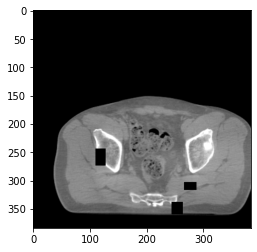

In [29]:
plt.imshow(x.squeeze(), 'gray'),

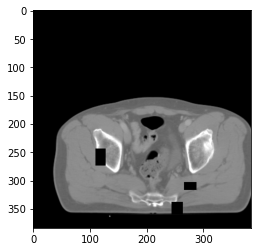

In [30]:
plt.imshow(y.squeeze(), 'gray')

In [31]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [33]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [34]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [35]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [36]:
edge_discriminator

Discriminator(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.01)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNor

In [37]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [38]:
from codes.scheduler import Scheduler
tf_scheduler = Scheduler(tf_dis_optimizer, name=DIS_scheduler, T_0=10, T_mult=2)
edge_scheduler = Scheduler(edge_dis_optimizer, name=E_scheduler, T_0=10, T_mult=2)

In [39]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [40]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis, tf_lr, edge_lr = train_a2b_epoch(epoch, model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer, tf_scheduler, 
                                                                                             edge_discriminator, edge_dis_optimizer, edge_scheduler,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "lr scheduler tf": tf_lr,
            "lr scheduler edge": edge_lr,
            
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_cont_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "tf_scheduler": tf_scheduler.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict(),
                "edge_scheduler": edge_scheduler.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

336it [01:31,  3.68it/s]
336it [03:22,  1.66it/s]
336it [01:11,  4.71it/s]
48it [00:07,  6.30it/s]
336it [01:34,  3.54it/s]
336it [03:19,  1.68it/s]
336it [01:15,  4.47it/s]
48it [00:09,  5.11it/s]
336it [01:26,  3.88it/s]
336it [03:21,  1.67it/s]
336it [01:04,  5.17it/s]
48it [00:09,  5.08it/s]
336it [01:27,  3.83it/s]
336it [03:21,  1.67it/s]
336it [01:04,  5.19it/s]
48it [00:10,  4.37it/s]
336it [01:30,  3.69it/s]
336it [03:22,  1.66it/s]
336it [01:11,  4.72it/s]
48it [00:11,  4.31it/s]
336it [01:31,  3.67it/s]
336it [03:20,  1.67it/s]
336it [01:11,  4.72it/s]
48it [00:09,  5.06it/s]
336it [01:26,  3.91it/s]
336it [03:19,  1.68it/s]
336it [01:04,  5.20it/s]
48it [00:09,  5.07it/s]
336it [01:28,  3.80it/s]
336it [03:21,  1.67it/s]
336it [01:08,  4.94it/s]
48it [00:11,  4.35it/s]
336it [01:34,  3.55it/s]
336it [03:22,  1.66it/s]
336it [01:11,  4.69it/s]
48it [00:10,  4.40it/s]
336it [01:28,  3.81it/s]
336it [03:21,  1.67it/s]
336it [01:08,  4.89it/s]
48it [00:09,  5.10it/s]
336it [01:

In [41]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [42]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [43]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8765868544578552
psnr score = 25.03335189819336
snr score = 15.096288681030273
mae error = 0.01796458102762699
air dice score = 0.9973580962520481
bone dice score = 0.9343966295525971
contour dice score = 0.38282647728919983


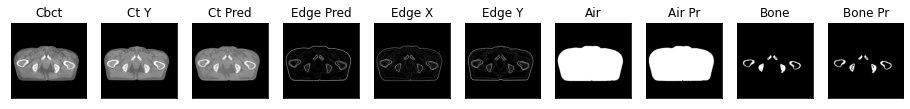

1it [00:00,  1.88it/s]

ssim score = 0.8768801093101501
psnr score = 24.989307403564453
snr score = 15.099778175354004
mae error = 0.018248526379466057
air dice score = 0.9975772617148284
bone dice score = 0.937161755863843
contour dice score = 0.4124327600002289


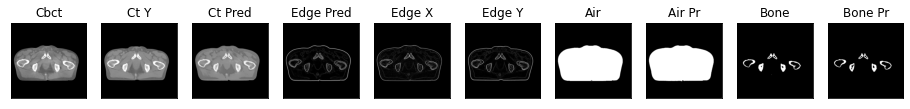

2it [00:00,  2.03it/s]

ssim score = 0.8716639280319214
psnr score = 24.741098403930664
snr score = 15.014467239379883
mae error = 0.0195468757301569
air dice score = 0.99722112731573
bone dice score = 0.9234889058923299
contour dice score = 0.4512268006801605


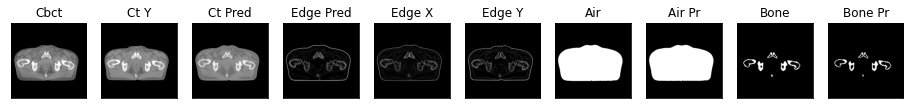

3it [00:01,  1.83it/s]

ssim score = 0.8676510453224182
psnr score = 24.708057403564453
snr score = 15.070677757263184
mae error = 0.020289460197091103
air dice score = 0.9976894365779986
bone dice score = 0.8964064146096639
contour dice score = 0.5275779366493225


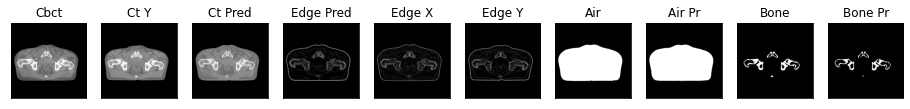

4it [00:01,  2.01it/s]

ssim score = 0.8682556748390198
psnr score = 24.807662963867188
snr score = 15.210586547851562
mae error = 0.02048499882221222
air dice score = 0.9973458514072956
bone dice score = 0.8740708822592472
contour dice score = 0.528279185295105


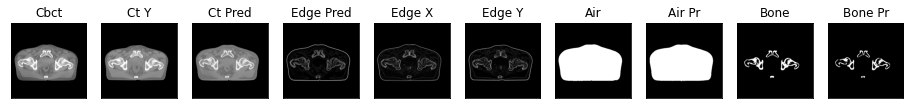

5it [00:02,  2.12it/s]

ssim score = 0.8632616996765137
psnr score = 24.542591094970703
snr score = 15.082049369812012
mae error = 0.021907810121774673
air dice score = 0.9975443654620495
bone dice score = 0.8414324654587703
contour dice score = 0.5488540530204773


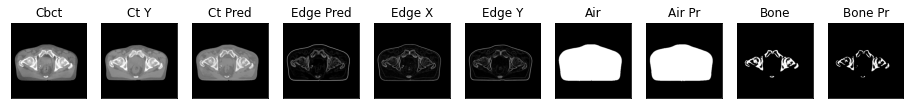

6it [00:02,  2.21it/s]

ssim score = 0.862582802772522
psnr score = 24.363933563232422
snr score = 14.87933349609375
mae error = 0.02197546698153019
air dice score = 0.9973779023218601
bone dice score = 0.8168234643071682
contour dice score = 0.5786924958229065


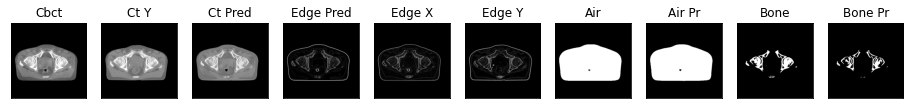

7it [00:03,  2.30it/s]

ssim score = 0.8660539984703064
psnr score = 24.969661712646484
snr score = 15.29952621459961
mae error = 0.019790111109614372
air dice score = 0.997011019976856
bone dice score = 0.8619033617576997
contour dice score = 0.5339806079864502


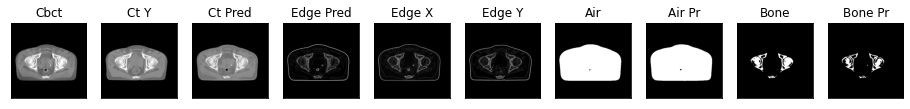

8it [00:03,  2.40it/s]

ssim score = 0.8682678937911987
psnr score = 25.397741317749023
snr score = 15.63305377960205
mae error = 0.018992139026522636
air dice score = 0.9969840498745072
bone dice score = 0.9025196199927455
contour dice score = 0.480195015668869


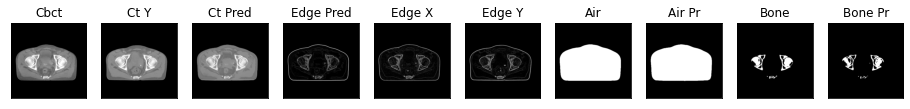

9it [00:04,  2.14it/s]

ssim score = 0.8723837733268738
psnr score = 25.40578842163086
snr score = 15.625816345214844
mae error = 0.018758252263069153
air dice score = 0.9967395512807483
bone dice score = 0.9050829320502399
contour dice score = 0.48136836290359497


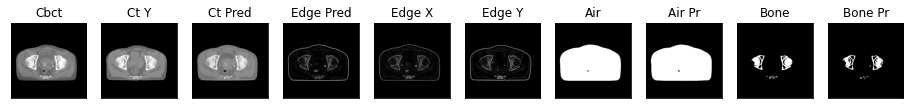

10it [00:04,  1.76it/s]

ssim score = 0.8778603076934814
psnr score = 25.805240631103516
snr score = 16.05753517150879
mae error = 0.01814976893365383
air dice score = 0.9966699796100325
bone dice score = 0.936627520497046
contour dice score = 0.5027523040771484


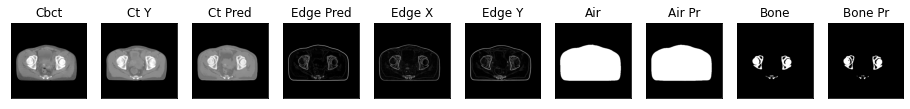

11it [00:05,  1.66it/s]

ssim score = 0.8775821924209595
psnr score = 24.967086791992188
snr score = 15.24309253692627
mae error = 0.019325988367199898
air dice score = 0.9966129784038567
bone dice score = 0.9163175178358473
contour dice score = 0.4779411852359772


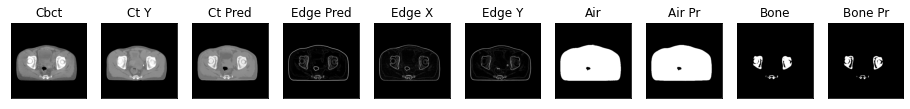

12it [00:06,  1.72it/s]

ssim score = 0.8826075196266174
psnr score = 24.483699798583984
snr score = 14.727783203125
mae error = 0.019635001197457314
air dice score = 0.9964174226393786
bone dice score = 0.9368207333102014
contour dice score = 0.43585020303726196


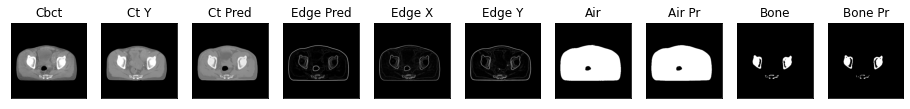

13it [00:06,  1.65it/s]

ssim score = 0.8805779218673706
psnr score = 24.43924331665039
snr score = 14.541372299194336
mae error = 0.018812410533428192
air dice score = 0.99629226657653
bone dice score = 0.9064234734350195
contour dice score = 0.42371833324432373


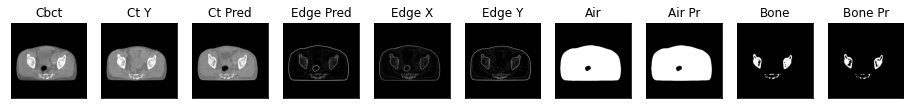

14it [00:07,  1.81it/s]

ssim score = 0.8775743246078491
psnr score = 24.35297966003418
snr score = 14.36944580078125
mae error = 0.018883127719163895
air dice score = 0.9956762384336768
bone dice score = 0.9080061051768002
contour dice score = 0.45488256216049194


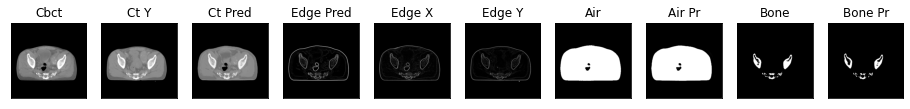

15it [00:07,  1.93it/s]

ssim score = 0.8694307804107666
psnr score = 24.03670310974121
snr score = 14.076651573181152
mae error = 0.02015063352882862
air dice score = 0.9961091157858772
bone dice score = 0.908242197920669
contour dice score = 0.5250626802444458


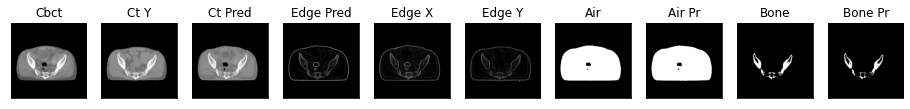

16it [00:08,  2.09it/s]

ssim score = 0.866860568523407
psnr score = 23.315107345581055
snr score = 13.352514266967773
mae error = 0.021620748564600945
air dice score = 0.9958040445549954
bone dice score = 0.9040294902770557
contour dice score = 0.515113353729248


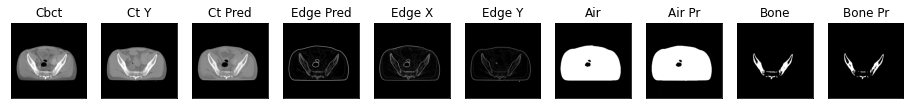

17it [00:08,  2.17it/s]

ssim score = 0.8578280806541443
psnr score = 22.70442008972168
snr score = 12.640067100524902
mae error = 0.023197470232844353
air dice score = 0.9946778864542979
bone dice score = 0.8723739495815077
contour dice score = 0.47299814224243164


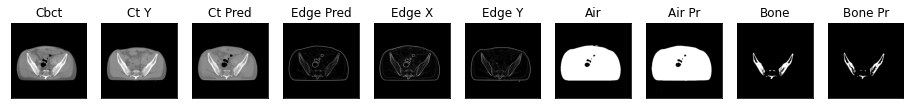

18it [00:08,  2.21it/s]

ssim score = 0.8553009629249573
psnr score = 22.4068546295166
snr score = 12.291820526123047
mae error = 0.024083871394395828
air dice score = 0.993406206311996
bone dice score = 0.8604620806701415
contour dice score = 0.4789271950721741


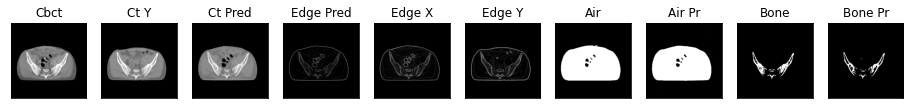

19it [00:09,  2.31it/s]

ssim score = 0.857327938079834
psnr score = 22.577136993408203
snr score = 12.449790954589844
mae error = 0.02397041954100132
air dice score = 0.9930038965639468
bone dice score = 0.877575435333277
contour dice score = 0.42793649435043335


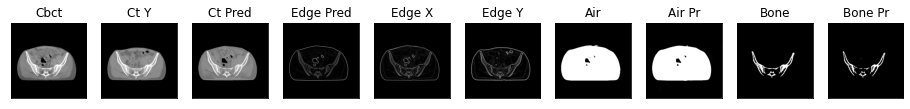

20it [00:09,  2.33it/s]

ssim score = 0.8582493662834167
psnr score = 22.636287689208984
snr score = 12.444096565246582
mae error = 0.02374018356204033
air dice score = 0.9932360032145803
bone dice score = 0.8772182946201527
contour dice score = 0.3354591727256775


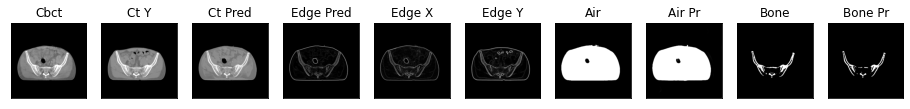

21it [00:10,  2.33it/s]

ssim score = 0.8577346205711365
psnr score = 22.54149627685547
snr score = 12.289875984191895
mae error = 0.02358497492969036
air dice score = 0.9916862603921839
bone dice score = 0.883288751233517
contour dice score = 0.3527131676673889


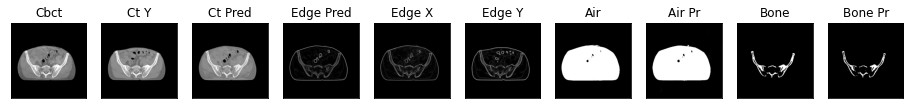

22it [00:10,  2.40it/s]

ssim score = 0.8610954880714417
psnr score = 22.750167846679688
snr score = 12.465118408203125
mae error = 0.02306445874273777
air dice score = 0.9926615926388814
bone dice score = 0.8874207188175552
contour dice score = 0.42282748222351074


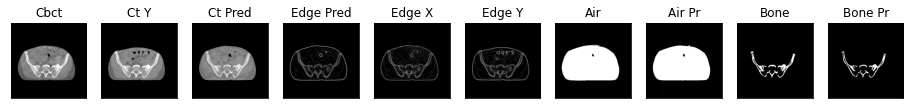

23it [00:11,  2.03it/s]

ssim score = 0.8612272143363953
psnr score = 22.83271026611328
snr score = 12.499095916748047
mae error = 0.02313476987183094
air dice score = 0.9928240634600477
bone dice score = 0.8828944004105996
contour dice score = 0.39498019218444824


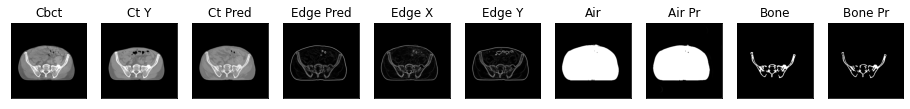

24it [00:11,  2.11it/s]

ssim score = 0.8631428480148315
psnr score = 22.633121490478516
snr score = 12.202509880065918
mae error = 0.02342800237238407
air dice score = 0.9923365855360409
bone dice score = 0.8775610960271839
contour dice score = 0.276324599981308


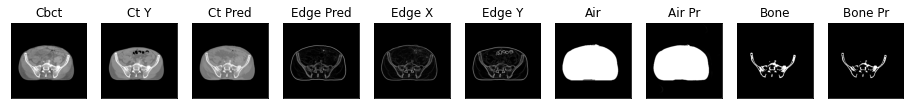

25it [00:12,  2.21it/s]

ssim score = 0.8648042678833008
psnr score = 22.712684631347656
snr score = 12.199334144592285
mae error = 0.02316303923726082
air dice score = 0.9919693526703485
bone dice score = 0.8674046740483714
contour dice score = 0.3405698835849762


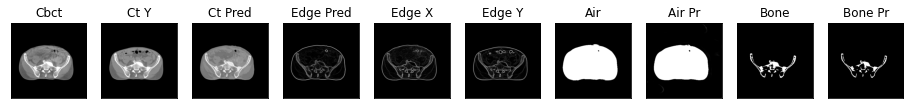

26it [00:12,  2.29it/s]

ssim score = 0.8631188869476318
psnr score = 22.743196487426758
snr score = 12.138662338256836
mae error = 0.02328890562057495
air dice score = 0.9919700669363656
bone dice score = 0.8625121241529763
contour dice score = 0.429660439491272


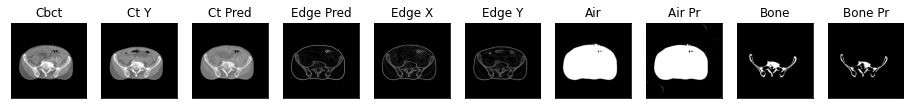

27it [00:12,  2.28it/s]

ssim score = 0.8657300472259521
psnr score = 22.502132415771484
snr score = 11.856491088867188
mae error = 0.02341439202427864
air dice score = 0.9917377759718373
bone dice score = 0.8763016363442464
contour dice score = 0.4709944725036621


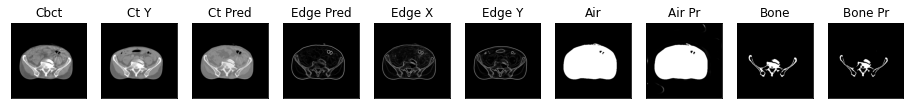

28it [00:13,  2.32it/s]

ssim score = 0.8418784737586975
psnr score = 23.791786193847656
snr score = 15.163942337036133
mae error = 0.02631525881588459
air dice score = 0.9964137281742245
bone dice score = 0.9587029672695411
contour dice score = 0.3960900902748108


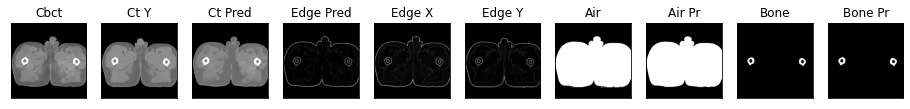

29it [00:13,  2.38it/s]

ssim score = 0.8490105867385864
psnr score = 24.47923469543457
snr score = 15.890647888183594
mae error = 0.02489037998020649
air dice score = 0.9956135238434147
bone dice score = 0.9567459180762892
contour dice score = 0.3709949553012848


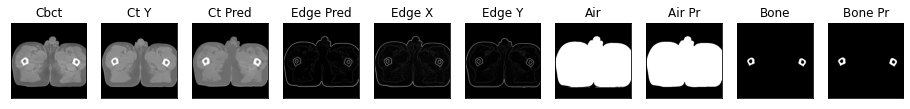

30it [00:14,  2.35it/s]

ssim score = 0.8565728664398193
psnr score = 24.96456527709961
snr score = 16.463430404663086
mae error = 0.024573849514126778
air dice score = 0.9956065785545
bone dice score = 0.960529317819746
contour dice score = 0.3423503339290619


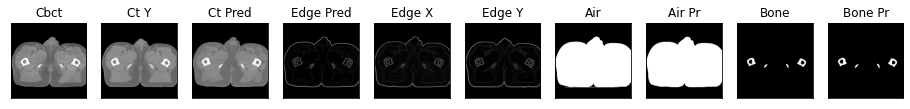

31it [00:14,  2.38it/s]

ssim score = 0.8609704375267029
psnr score = 25.08533477783203
snr score = 16.746753692626953
mae error = 0.025950996205210686
air dice score = 0.9967536793652736
bone dice score = 0.9606224198164398
contour dice score = 0.3471074402332306


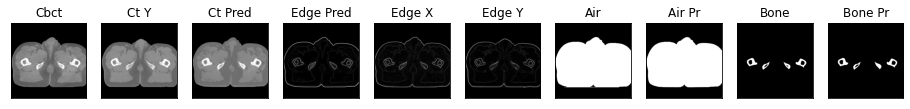

32it [00:14,  2.41it/s]

ssim score = 0.8633670806884766
psnr score = 25.215091705322266
snr score = 17.004655838012695
mae error = 0.026358479633927345
air dice score = 0.9970705597280339
bone dice score = 0.9542665923040398
contour dice score = 0.3204830586910248


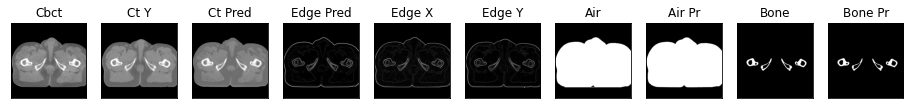

33it [00:15,  2.02it/s]

ssim score = 0.8659965991973877
psnr score = 25.369834899902344
snr score = 17.262638092041016
mae error = 0.027116160839796066
air dice score = 0.9975087493921964
bone dice score = 0.9459022509644832
contour dice score = 0.34248489141464233


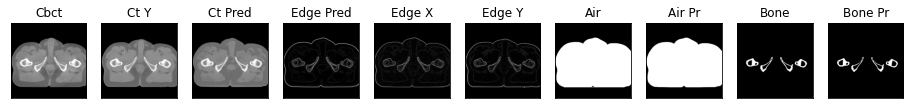

34it [00:16,  2.08it/s]

ssim score = 0.864986002445221
psnr score = 25.5113582611084
snr score = 17.47126007080078
mae error = 0.027622707188129425
air dice score = 0.9972912368822332
bone dice score = 0.9267501159025642
contour dice score = 0.31040892004966736


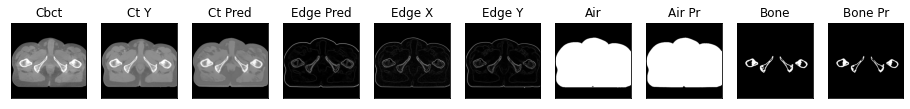

35it [00:16,  2.14it/s]

ssim score = 0.8615074157714844
psnr score = 25.52288246154785
snr score = 17.4728946685791
mae error = 0.027419673278927803
air dice score = 0.9975440520756351
bone dice score = 0.935681470138529
contour dice score = 0.35370370745658875


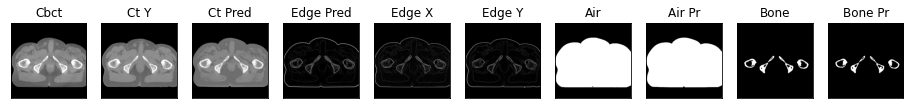

36it [00:16,  2.16it/s]

ssim score = 0.8632010817527771
psnr score = 25.720060348510742
snr score = 17.656410217285156
mae error = 0.02667939104139805
air dice score = 0.9974360042118554
bone dice score = 0.9421665947351946
contour dice score = 0.3444444537162781


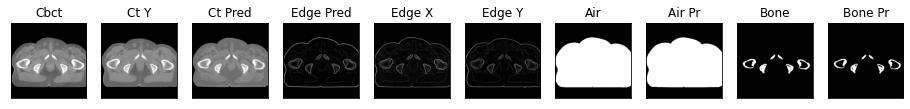

37it [00:17,  2.25it/s]

ssim score = 0.8648834824562073
psnr score = 25.938838958740234
snr score = 17.887189865112305
mae error = 0.02643684670329094
air dice score = 0.9975580048126927
bone dice score = 0.9374499714129508
contour dice score = 0.3857209086418152


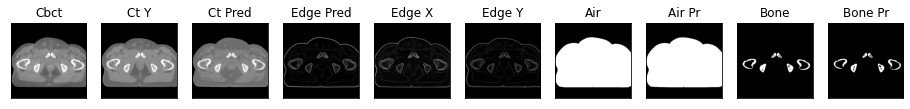

38it [00:17,  2.27it/s]

ssim score = 0.8642653822898865
psnr score = 25.782854080200195
snr score = 17.770288467407227
mae error = 0.02719270996749401
air dice score = 0.9975947690681377
bone dice score = 0.9332389714563193
contour dice score = 0.4143389165401459


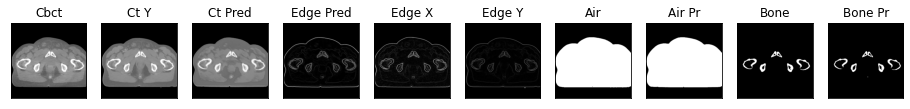

39it [00:18,  2.28it/s]

ssim score = 0.8611470460891724
psnr score = 25.41110610961914
snr score = 17.53982925415039
mae error = 0.029213547706604004
air dice score = 0.9976775818340584
bone dice score = 0.9116067740612185
contour dice score = 0.4136321246623993


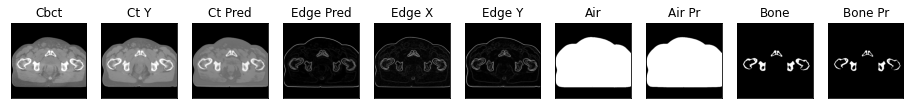

40it [00:18,  2.36it/s]

ssim score = 0.8549187779426575
psnr score = 25.005779266357422
snr score = 17.229190826416016
mae error = 0.03175060823559761
air dice score = 0.9976747643543173
bone dice score = 0.8809482001766379
contour dice score = 0.40505144000053406


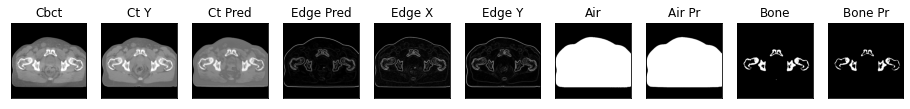

41it [00:19,  2.35it/s]

ssim score = 0.8453462719917297
psnr score = 24.429649353027344
snr score = 16.61901092529297
mae error = 0.032456472516059875
air dice score = 0.9974278024122574
bone dice score = 0.8457032957439837
contour dice score = 0.40900564193725586


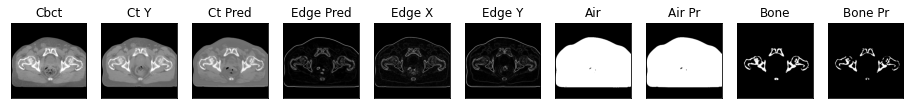

42it [00:19,  2.34it/s]

ssim score = 0.8417560458183289
psnr score = 23.50458526611328
snr score = 15.766136169433594
mae error = 0.03528671711683273
air dice score = 0.9967386799762178
bone dice score = 0.784635844482636
contour dice score = 0.39472445845603943


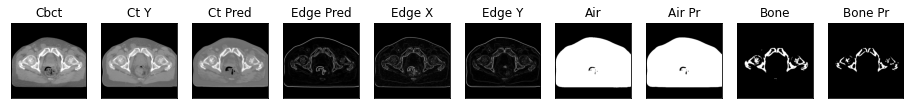

43it [00:20,  2.02it/s]

ssim score = 0.8489654064178467
psnr score = 23.852529525756836
snr score = 15.977984428405762
mae error = 0.0333472304046154
air dice score = 0.997524051639489
bone dice score = 0.8451569549789272
contour dice score = 0.4233852028846741


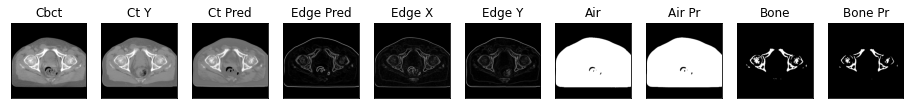

44it [00:20,  2.15it/s]

ssim score = 0.8541829586029053
psnr score = 24.400671005249023
snr score = 16.347564697265625
mae error = 0.030097845941781998
air dice score = 0.9975956020056802
bone dice score = 0.8872764435371765
contour dice score = 0.4905303120613098


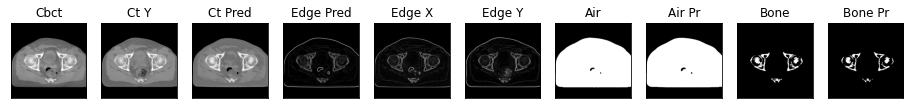

45it [00:20,  2.20it/s]

ssim score = 0.8508909940719604
psnr score = 24.72404670715332
snr score = 16.580352783203125
mae error = 0.029297202825546265
air dice score = 0.9977858171302751
bone dice score = 0.896700306158332
contour dice score = 0.46885401010513306


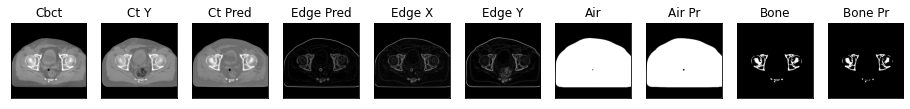

46it [00:21,  2.23it/s]

ssim score = 0.8502705097198486
psnr score = 24.717559814453125
snr score = 16.589553833007812
mae error = 0.02906922437250614
air dice score = 0.998214047066543
bone dice score = 0.8984890402224038
contour dice score = 0.4880838990211487


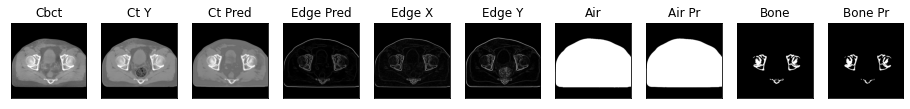

47it [00:21,  2.30it/s]

ssim score = 0.8429002165794373
psnr score = 24.586864471435547
snr score = 16.468894958496094
mae error = 0.029111066833138466
air dice score = 0.998070417546989
bone dice score = 0.8993625651931683
contour dice score = 0.4871060252189636


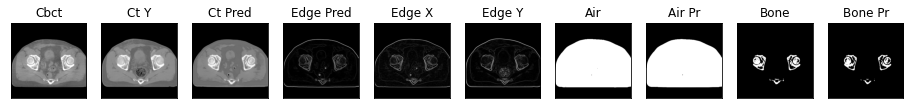

48it [00:22,  2.29it/s]

ssim score = 0.8478737473487854
psnr score = 24.69512176513672
snr score = 16.638744354248047
mae error = 0.029189007356762886
air dice score = 0.9979105264125405
bone dice score = 0.8916827853008541
contour dice score = 0.5279236435890198


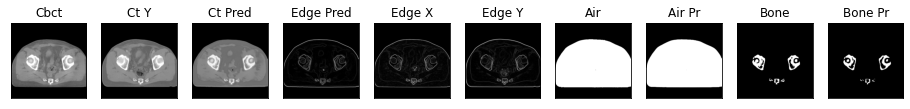

49it [00:22,  2.30it/s]

ssim score = 0.853537380695343
psnr score = 24.88388442993164
snr score = 16.897586822509766
mae error = 0.029641181230545044
air dice score = 0.9976785319478236
bone dice score = 0.9140784824259431
contour dice score = 0.5104761719703674


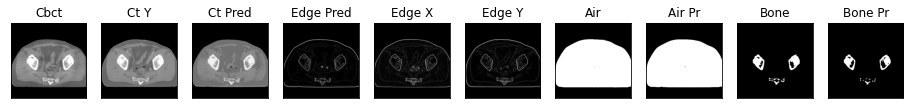

50it [00:23,  2.27it/s]

ssim score = 0.8581083416938782
psnr score = 24.929201126098633
snr score = 16.82379722595215
mae error = 0.02870054356753826
air dice score = 0.9977338745831633
bone dice score = 0.9114132674092356
contour dice score = 0.5021438598632812


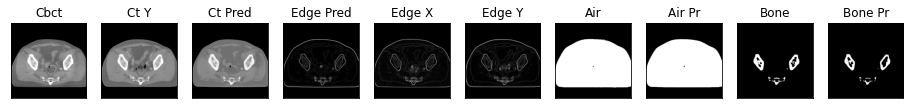

51it [00:23,  2.35it/s]

ssim score = 0.851875364780426
psnr score = 24.258586883544922
snr score = 16.23480987548828
mae error = 0.03087516315281391
air dice score = 0.9972375351446935
bone dice score = 0.8921837818058559
contour dice score = 0.4645593762397766


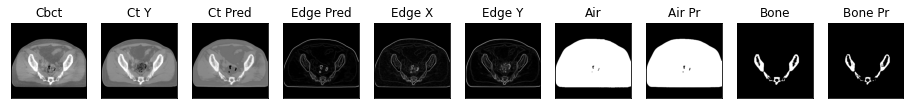

52it [00:23,  2.35it/s]

ssim score = 0.8510267734527588
psnr score = 24.283124923706055
snr score = 16.339496612548828
mae error = 0.03167757764458656
air dice score = 0.996740515635724
bone dice score = 0.8466746316220894
contour dice score = 0.4380403459072113


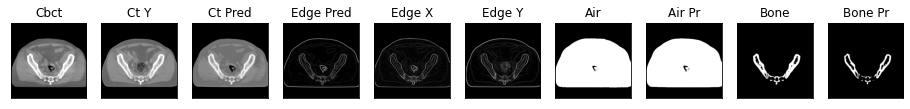

53it [00:24,  2.02it/s]

ssim score = 0.8337076306343079
psnr score = 23.84252166748047
snr score = 15.920448303222656
mae error = 0.03271524980664253
air dice score = 0.9967783938428829
bone dice score = 0.8253761691758814
contour dice score = 0.39903613924980164


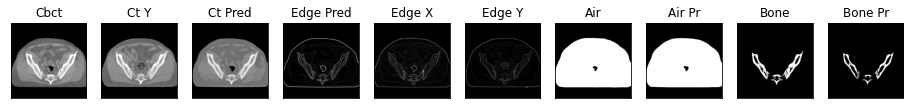

54it [00:25,  2.10it/s]

ssim score = 0.840481698513031
psnr score = 24.40345001220703
snr score = 16.493915557861328
mae error = 0.031504902988672256
air dice score = 0.9966590064333852
bone dice score = 0.8313738386924988
contour dice score = 0.3339749872684479


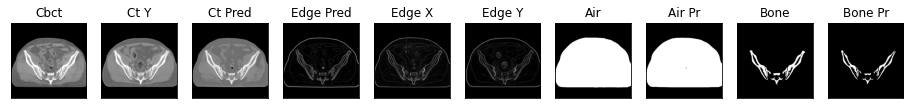

55it [00:25,  2.21it/s]

ssim score = 0.800894558429718
psnr score = 20.64935874938965
snr score = 10.52956771850586
mae error = 0.03282955288887024
air dice score = 0.9972823171821944
bone dice score = 0.9357607282201362
contour dice score = 0.5


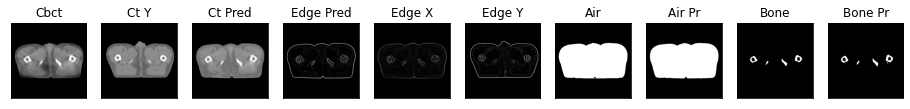

56it [00:25,  2.25it/s]

ssim score = 0.7908225059509277
psnr score = 20.353530883789062
snr score = 10.446721076965332
mae error = 0.03471903130412102
air dice score = 0.9974499542413414
bone dice score = 0.9249061326673987
contour dice score = 0.4925946295261383


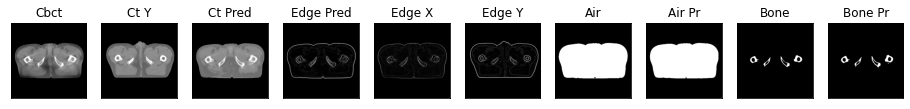

57it [00:26,  2.29it/s]

ssim score = 0.7854686975479126
psnr score = 20.3316650390625
snr score = 10.555991172790527
mae error = 0.03542708605527878
air dice score = 0.9974103568051074
bone dice score = 0.9133919843614196
contour dice score = 0.46305418014526367


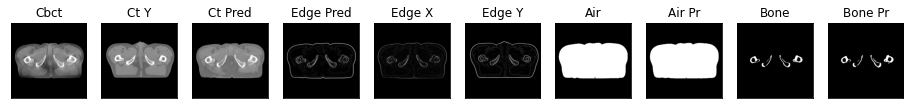

58it [00:26,  2.37it/s]

ssim score = 0.7899239659309387
psnr score = 20.713376998901367
snr score = 11.008105278015137
mae error = 0.03408614173531532
air dice score = 0.9974412858637661
bone dice score = 0.9117424242440958
contour dice score = 0.43763676285743713


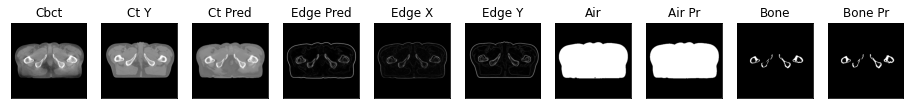

59it [00:27,  2.34it/s]

ssim score = 0.7916194796562195
psnr score = 20.82596206665039
snr score = 11.168259620666504
mae error = 0.03382951766252518
air dice score = 0.9972047213045827
bone dice score = 0.9165743816922005
contour dice score = 0.48309704661369324


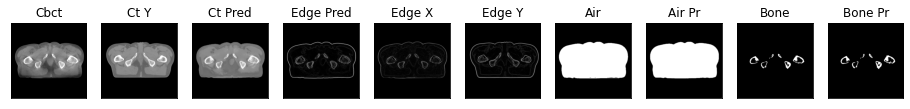

60it [00:27,  2.37it/s]

ssim score = 0.7908201217651367
psnr score = 20.956382751464844
snr score = 11.304292678833008
mae error = 0.03352846950292587
air dice score = 0.9969534816728817
bone dice score = 0.9222520107252502
contour dice score = 0.4710875451564789


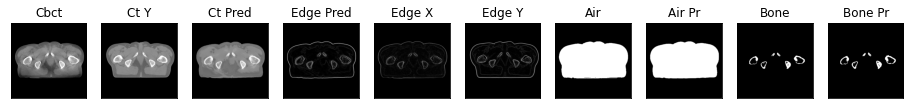

61it [00:27,  2.43it/s]

ssim score = 0.7911251783370972
psnr score = 21.02271270751953
snr score = 11.364124298095703
mae error = 0.03307899087667465
air dice score = 0.997050712092083
bone dice score = 0.9210574293542195
contour dice score = 0.5053191781044006


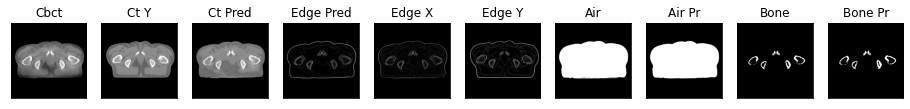

62it [00:28,  2.41it/s]

ssim score = 0.7920774817466736
psnr score = 20.864635467529297
snr score = 11.220155715942383
mae error = 0.03332025185227394
air dice score = 0.9967657744366146
bone dice score = 0.9349048050782429
contour dice score = 0.47664543986320496


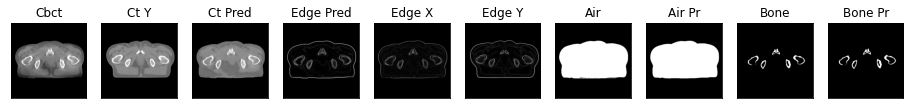

63it [00:28,  2.07it/s]

ssim score = 0.791073739528656
psnr score = 20.78396224975586
snr score = 11.197490692138672
mae error = 0.03394317254424095
air dice score = 0.996006687282905
bone dice score = 0.9241628365081391
contour dice score = 0.5034666657447815


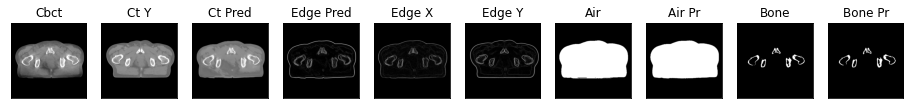

64it [00:29,  2.18it/s]

ssim score = 0.7798544764518738
psnr score = 20.53683853149414
snr score = 11.048921585083008
mae error = 0.03612161800265312
air dice score = 0.9960871705838182
bone dice score = 0.900184275185808
contour dice score = 0.46543535590171814


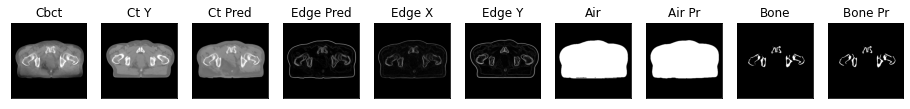

65it [00:29,  2.28it/s]

ssim score = 0.7702098488807678
psnr score = 20.365169525146484
snr score = 10.913082122802734
mae error = 0.037676215171813965
air dice score = 0.9961357990615546
bone dice score = 0.9008875739659632
contour dice score = 0.4436090290546417


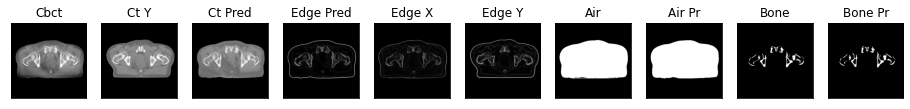

66it [00:30,  2.30it/s]

ssim score = 0.762371301651001
psnr score = 20.250720977783203
snr score = 10.831341743469238
mae error = 0.038134027272462845
air dice score = 0.9964579042169068
bone dice score = 0.8805684613298638
contour dice score = 0.49331194162368774


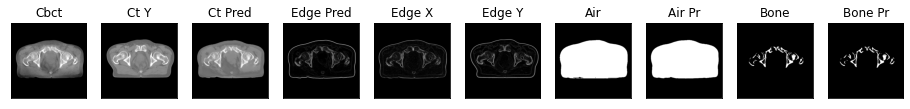

67it [00:30,  2.30it/s]

ssim score = 0.7619947791099548
psnr score = 20.312929153442383
snr score = 11.010366439819336
mae error = 0.03839578106999397
air dice score = 0.9968723882718895
bone dice score = 0.9077159702652177
contour dice score = 0.5675105452537537


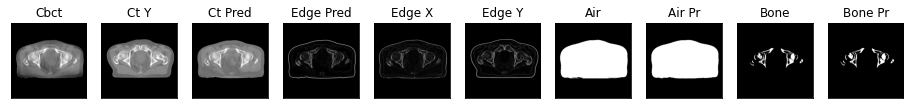

68it [00:31,  2.38it/s]

ssim score = 0.7634776830673218
psnr score = 20.320106506347656
snr score = 11.001557350158691
mae error = 0.03846151381731033
air dice score = 0.9972776456804187
bone dice score = 0.9017646241503159
contour dice score = 0.5524741411209106


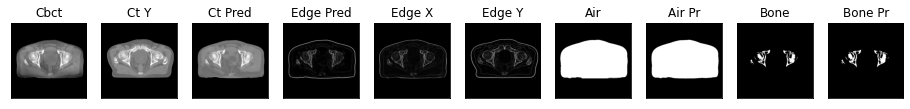

69it [00:31,  2.37it/s]

ssim score = 0.7801102995872498
psnr score = 20.8402042388916
snr score = 11.322490692138672
mae error = 0.03518931567668915
air dice score = 0.9975295889821412
bone dice score = 0.9122497055372166
contour dice score = 0.5729613900184631


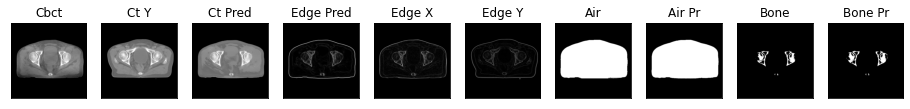

70it [00:31,  2.37it/s]

ssim score = 0.7950378656387329
psnr score = 21.397502899169922
snr score = 11.709396362304688
mae error = 0.032682109624147415
air dice score = 0.9971204841024961
bone dice score = 0.9317711922821258
contour dice score = 0.5476062297821045


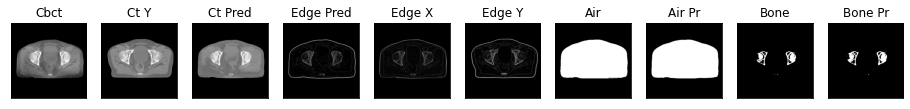

71it [00:32,  2.44it/s]

ssim score = 0.8004692196846008
psnr score = 21.744354248046875
snr score = 12.070418357849121
mae error = 0.03146672621369362
air dice score = 0.9970833476306513
bone dice score = 0.93945389790345
contour dice score = 0.5496264696121216


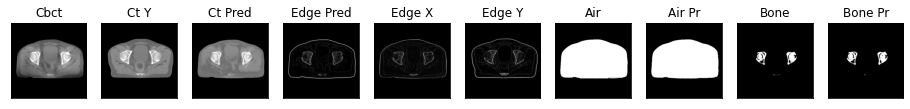

72it [00:32,  2.41it/s]

ssim score = 0.806343674659729
psnr score = 21.961437225341797
snr score = 12.369329452514648
mae error = 0.030892154201865196
air dice score = 0.997321145830661
bone dice score = 0.9505682596200113
contour dice score = 0.5669376850128174


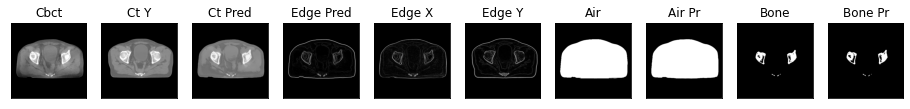

73it [00:33,  2.07it/s]

ssim score = 0.8059465289115906
psnr score = 21.960535049438477
snr score = 12.460602760314941
mae error = 0.0313180610537529
air dice score = 0.9972954295318642
bone dice score = 0.9372197309426424
contour dice score = 0.5420560836791992


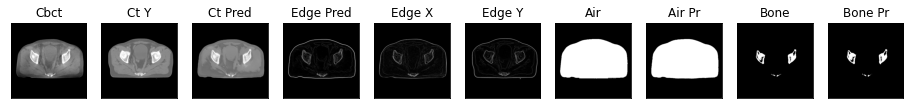

74it [00:33,  2.16it/s]

ssim score = 0.8027861714363098
psnr score = 22.195226669311523
snr score = 12.631866455078125
mae error = 0.030338171869516373
air dice score = 0.9967619937959489
bone dice score = 0.9558629776028349
contour dice score = 0.5436997413635254


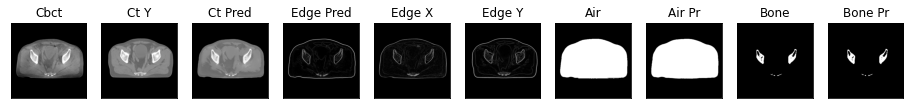

75it [00:34,  2.24it/s]

ssim score = 0.804935097694397
psnr score = 22.3145694732666
snr score = 12.714813232421875
mae error = 0.029511885717511177
air dice score = 0.9965684775592052
bone dice score = 0.945078459344774
contour dice score = 0.504792332649231


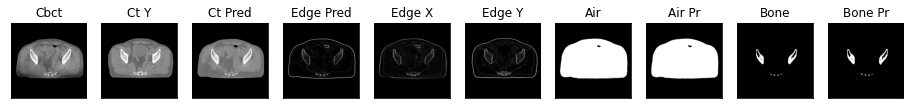

76it [00:34,  2.27it/s]

ssim score = 0.8011184334754944
psnr score = 22.098426818847656
snr score = 12.536418914794922
mae error = 0.030877942219376564
air dice score = 0.9964154661592854
bone dice score = 0.9160305343525385
contour dice score = 0.5591511726379395


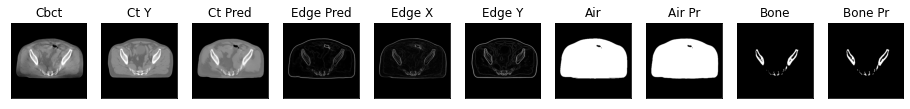

77it [00:34,  2.32it/s]

ssim score = 0.7976732850074768
psnr score = 22.013227462768555
snr score = 12.581720352172852
mae error = 0.03137434273958206
air dice score = 0.9967448857310436
bone dice score = 0.9158878504685375
contour dice score = 0.576615035533905


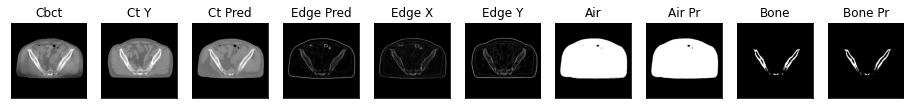

78it [00:35,  2.40it/s]

ssim score = 0.8004606366157532
psnr score = 21.942169189453125
snr score = 12.528411865234375
mae error = 0.03189864754676819
air dice score = 0.9966712756695886
bone dice score = 0.9000322476636564
contour dice score = 0.5298226475715637


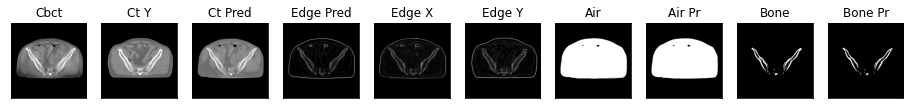

79it [00:35,  2.39it/s]

ssim score = 0.8025392889976501
psnr score = 22.3941707611084
snr score = 12.969146728515625
mae error = 0.030266085639595985
air dice score = 0.9968797682113555
bone dice score = 0.9133830932144874
contour dice score = 0.5666486620903015


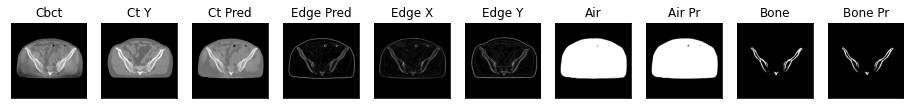

80it [00:36,  2.37it/s]

ssim score = 0.8032298684120178
psnr score = 22.38595962524414
snr score = 12.96019458770752
mae error = 0.030340462923049927
air dice score = 0.996386848127186
bone dice score = 0.9003344481622018
contour dice score = 0.5345672369003296


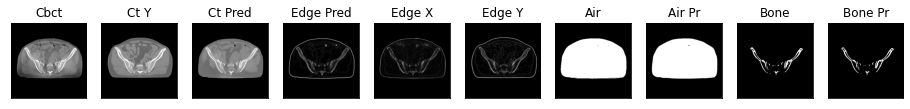

81it [00:36,  2.43it/s]

ssim score = 0.8408079743385315
psnr score = 23.334609985351562
snr score = 13.768744468688965
mae error = 0.02332315780222416
air dice score = 0.996757308007938
bone dice score = 0.8973198746990143
contour dice score = 0.4532908797264099


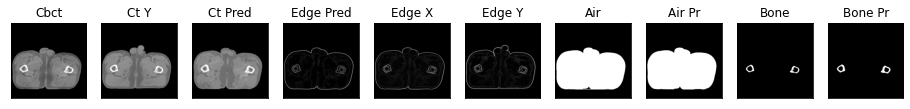

82it [00:37,  2.41it/s]

ssim score = 0.8390519022941589
psnr score = 23.56670379638672
snr score = 14.065229415893555
mae error = 0.023150742053985596
air dice score = 0.9962889404094064
bone dice score = 0.8804755944968562
contour dice score = 0.44700944423675537


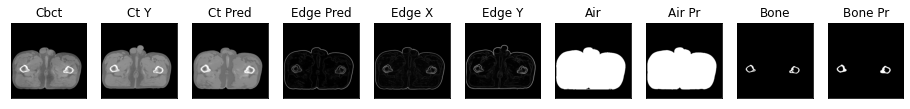

83it [00:37,  2.05it/s]

ssim score = 0.850106954574585
psnr score = 24.790441513061523
snr score = 15.428180694580078
mae error = 0.021567871794104576
air dice score = 0.9968872690869869
bone dice score = 0.9190788083684961
contour dice score = 0.48884379863739014


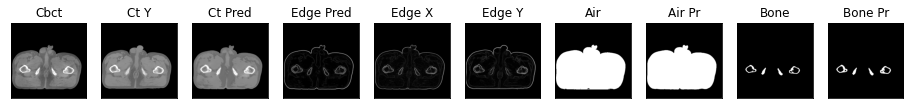

84it [00:38,  2.17it/s]

ssim score = 0.8528609275817871
psnr score = 24.81513023376465
snr score = 15.574360847473145
mae error = 0.02177947200834751
air dice score = 0.9976969998755153
bone dice score = 0.9068972451255399
contour dice score = 0.4966580867767334


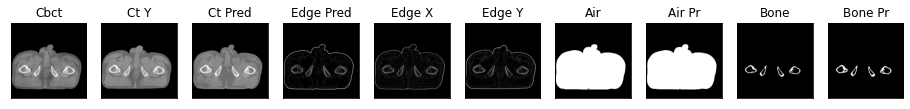

85it [00:38,  2.27it/s]

ssim score = 0.8461726307868958
psnr score = 24.602479934692383
snr score = 15.385883331298828
mae error = 0.022258782759308815
air dice score = 0.9980130085844254
bone dice score = 0.8854652341397635
contour dice score = 0.5288311839103699


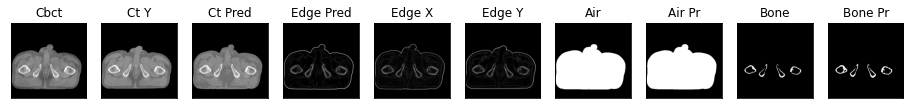

86it [00:38,  2.29it/s]

ssim score = 0.8458824157714844
psnr score = 24.416410446166992
snr score = 15.195417404174805
mae error = 0.022630225867033005
air dice score = 0.9978753760739447
bone dice score = 0.882986627045264
contour dice score = 0.5151832699775696


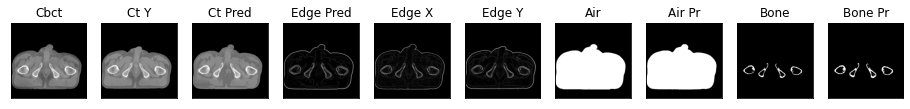

87it [00:39,  2.33it/s]

ssim score = 0.8481337428092957
psnr score = 24.13254737854004
snr score = 14.917808532714844
mae error = 0.022952523082494736
air dice score = 0.9977759696230014
bone dice score = 0.9027700316061951
contour dice score = 0.5105262994766235


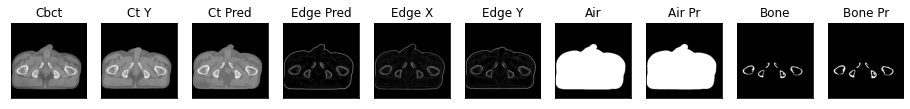

88it [00:39,  2.41it/s]

ssim score = 0.8460713624954224
psnr score = 23.922090530395508
snr score = 14.685794830322266
mae error = 0.022894883528351784
air dice score = 0.9978901971734864
bone dice score = 0.9113355780039032
contour dice score = 0.5437302589416504


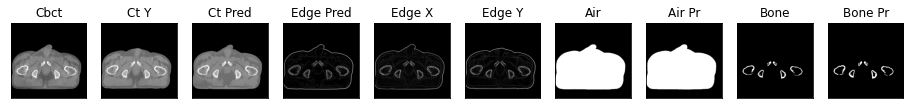

89it [00:40,  2.39it/s]

ssim score = 0.8478829264640808
psnr score = 23.933670043945312
snr score = 14.714284896850586
mae error = 0.023049550130963326
air dice score = 0.9977366591221989
bone dice score = 0.9234629861996153
contour dice score = 0.5227513313293457


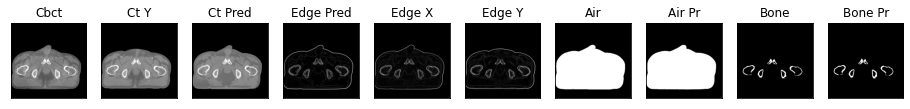

90it [00:40,  2.37it/s]

ssim score = 0.8469175100326538
psnr score = 24.179859161376953
snr score = 15.029068946838379
mae error = 0.023016253486275673
air dice score = 0.9978363262851223
bone dice score = 0.9317361339033191
contour dice score = 0.5816435217857361


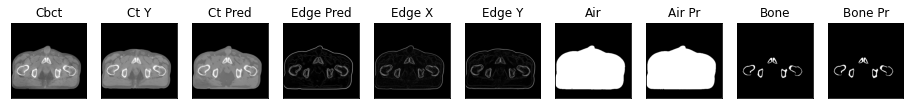

91it [00:40,  2.43it/s]

ssim score = 0.8448190093040466
psnr score = 24.432174682617188
snr score = 15.362743377685547
mae error = 0.023413943126797676
air dice score = 0.9977959228494577
bone dice score = 0.9255974748245063
contour dice score = 0.5882984399795532


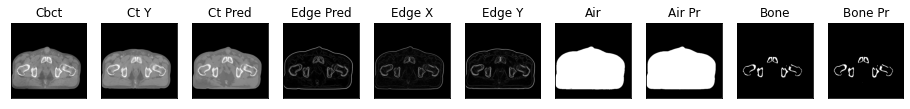

92it [00:41,  2.40it/s]

ssim score = 0.8451801538467407
psnr score = 24.632389068603516
snr score = 15.61366081237793
mae error = 0.023677801713347435
air dice score = 0.998338464930587
bone dice score = 0.9107066074256742
contour dice score = 0.5996776223182678


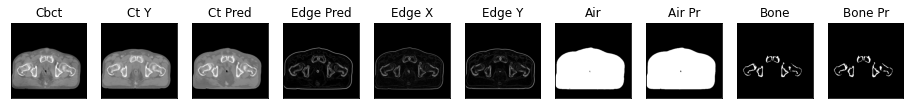

93it [00:42,  2.07it/s]

ssim score = 0.8482580780982971
psnr score = 24.82809066772461
snr score = 15.925630569458008
mae error = 0.024336926639080048
air dice score = 0.9983257782761847
bone dice score = 0.8912087912102856
contour dice score = 0.6136485934257507


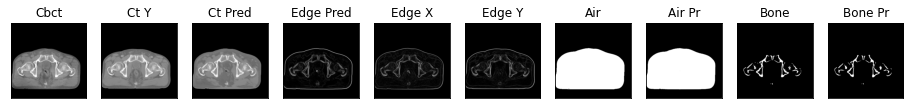

94it [00:42,  2.16it/s]

ssim score = 0.8490530252456665
psnr score = 24.610422134399414
snr score = 15.66972541809082
mae error = 0.02424336038529873
air dice score = 0.9982847613753686
bone dice score = 0.8835284042266125
contour dice score = 0.6232507824897766


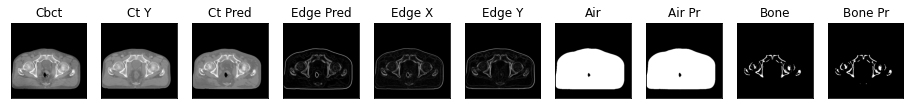

95it [00:42,  2.27it/s]

ssim score = 0.8411094546318054
psnr score = 24.006004333496094
snr score = 14.969636917114258
mae error = 0.024877609685063362
air dice score = 0.9974859887910349
bone dice score = 0.8901386345816095
contour dice score = 0.54830002784729


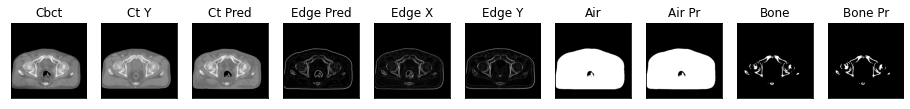

96it [00:43,  2.29it/s]

ssim score = 0.8465745449066162
psnr score = 23.89725685119629
snr score = 14.701131820678711
mae error = 0.023813625797629356
air dice score = 0.9977590404178843
bone dice score = 0.8777285910566672
contour dice score = 0.540043294429779


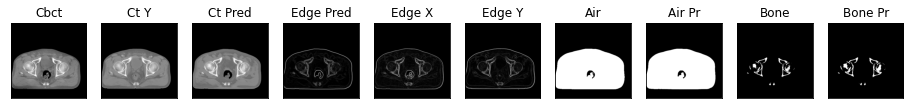

97it [00:43,  2.32it/s]

ssim score = 0.8451675176620483
psnr score = 23.67447280883789
snr score = 14.361921310424805
mae error = 0.02378343977034092
air dice score = 0.9975317894119488
bone dice score = 0.8766183122777005
contour dice score = 0.5260869860649109


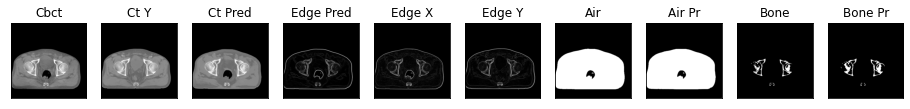

98it [00:44,  2.40it/s]

ssim score = 0.8410848379135132
psnr score = 23.63775634765625
snr score = 14.28011417388916
mae error = 0.02405489794909954
air dice score = 0.9975973562718862
bone dice score = 0.8974206937459618
contour dice score = 0.541689395904541


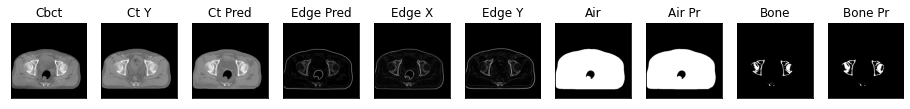

99it [00:44,  2.38it/s]

ssim score = 0.8358258605003357
psnr score = 23.256731033325195
snr score = 13.905759811401367
mae error = 0.025004694238305092
air dice score = 0.9975607552624467
bone dice score = 0.9174564353421361
contour dice score = 0.5084561109542847


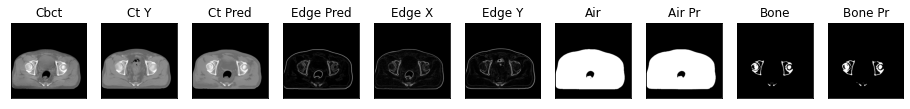

100it [00:44,  2.38it/s]

ssim score = 0.8384391069412231
psnr score = 23.02783966064453
snr score = 13.706972122192383
mae error = 0.025790229439735413
air dice score = 0.9974323100979364
bone dice score = 0.9375746714465715
contour dice score = 0.4958949089050293


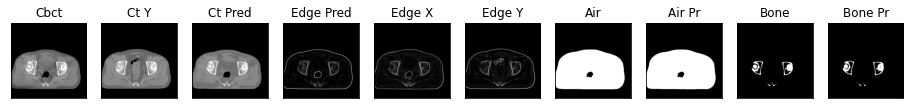

101it [00:45,  2.44it/s]

ssim score = 0.8453449010848999
psnr score = 23.735416412353516
snr score = 14.371962547302246
mae error = 0.024013152346014977
air dice score = 0.9971805979105213
bone dice score = 0.9426751592366297
contour dice score = 0.49288061261177063


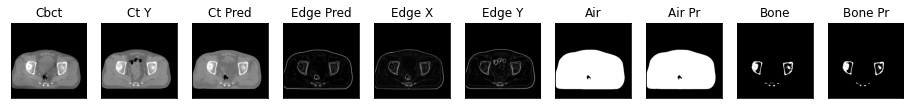

102it [00:45,  2.42it/s]

ssim score = 0.8500216007232666
psnr score = 24.037580490112305
snr score = 14.583921432495117
mae error = 0.022702081128954887
air dice score = 0.9972103464782711
bone dice score = 0.9181752353381938
contour dice score = 0.48521357774734497


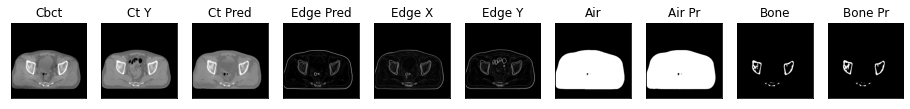

103it [00:46,  2.04it/s]

ssim score = 0.851581871509552
psnr score = 23.785865783691406
snr score = 14.266481399536133
mae error = 0.022799024358391762
air dice score = 0.9972564357013624
bone dice score = 0.9315016218292024
contour dice score = 0.5219298005104065


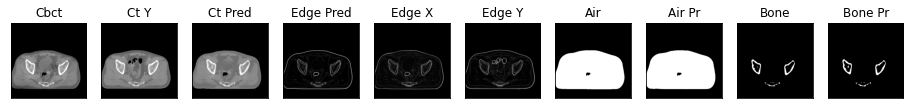

104it [00:46,  2.16it/s]

ssim score = 0.8486353158950806
psnr score = 23.766483306884766
snr score = 14.246796607971191
mae error = 0.023124098777770996
air dice score = 0.9971688523350691
bone dice score = 0.9290633608827641
contour dice score = 0.5145684480667114


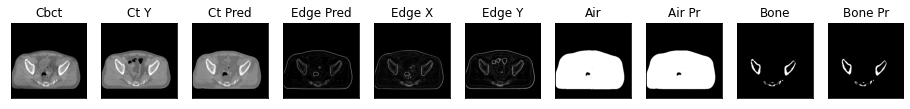

105it [00:47,  2.27it/s]

ssim score = 0.843173086643219
psnr score = 23.622196197509766
snr score = 14.178675651550293
mae error = 0.024355873465538025
air dice score = 0.9975661671797241
bone dice score = 0.914973882763857
contour dice score = 0.5583195090293884


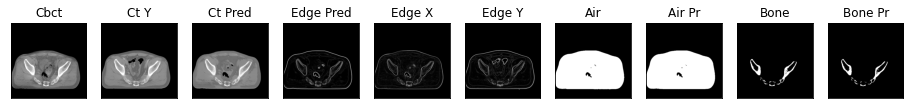

106it [00:47,  2.29it/s]

ssim score = 0.8476243615150452
psnr score = 23.818946838378906
snr score = 14.411008834838867
mae error = 0.023786375299096107
air dice score = 0.9977382710148781
bone dice score = 0.9071339864784445
contour dice score = 0.5458563566207886


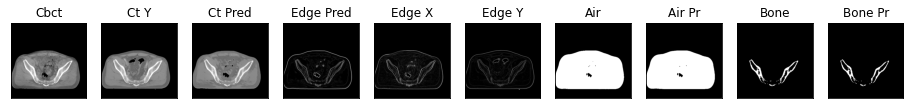

107it [00:47,  2.32it/s]

ssim score = 0.8496946096420288
psnr score = 24.452974319458008
snr score = 14.983339309692383
mae error = 0.022634515538811684
air dice score = 0.9977081348337774
bone dice score = 0.8988698077220186
contour dice score = 0.5590682029724121


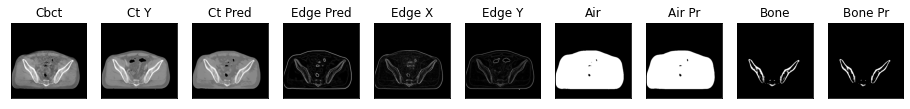

108it [00:48,  2.39it/s]

ssim score = 0.8484847545623779
psnr score = 24.320816040039062
snr score = 14.78991985321045
mae error = 0.022735441103577614
air dice score = 0.9975164201836313
bone dice score = 0.8985638699939749
contour dice score = 0.5030812621116638


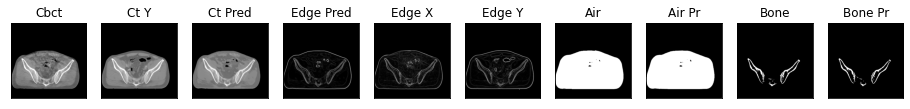

109it [00:48,  2.38it/s]

ssim score = 0.791551947593689
psnr score = 21.603147506713867
snr score = 13.300455093383789
mae error = 0.036981821060180664
air dice score = 0.9970597650183189
bone dice score = 0.9410356180801845
contour dice score = 0.37599295377731323


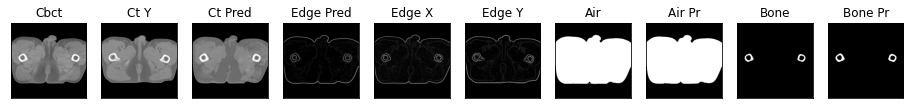

110it [00:49,  2.37it/s]

ssim score = 0.7827666997909546
psnr score = 21.208227157592773
snr score = 13.009824752807617
mae error = 0.03928127512335777
air dice score = 0.9971058572497998
bone dice score = 0.9332977588064755
contour dice score = 0.41403821110725403


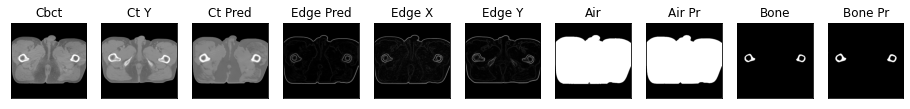

111it [00:49,  2.40it/s]

ssim score = 0.7797647714614868
psnr score = 20.889394760131836
snr score = 12.818950653076172
mae error = 0.041933316737413406
air dice score = 0.9971332565735384
bone dice score = 0.9068791946328255
contour dice score = 0.3887147307395935


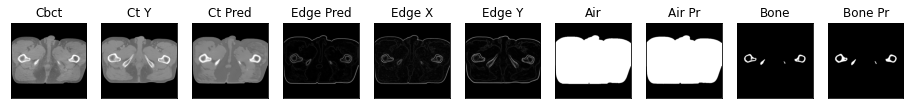

112it [00:50,  2.37it/s]

ssim score = 0.7703447937965393
psnr score = 20.56708526611328
snr score = 12.528928756713867
mae error = 0.04364428296685219
air dice score = 0.9970354225987527
bone dice score = 0.9258188824674723
contour dice score = 0.3664122223854065


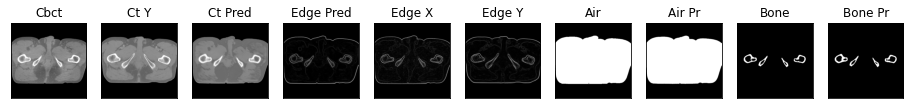

113it [00:50,  2.04it/s]

ssim score = 0.7594559788703918
psnr score = 20.419771194458008
snr score = 12.411852836608887
mae error = 0.04509420692920685
air dice score = 0.9970607656033629
bone dice score = 0.9135648652871272
contour dice score = 0.3852052390575409


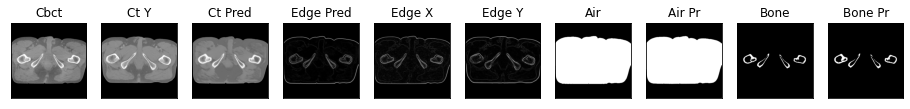

114it [00:51,  2.15it/s]

ssim score = 0.7549793720245361
psnr score = 20.26871681213379
snr score = 12.295217514038086
mae error = 0.046475544571876526
air dice score = 0.9971050623547452
bone dice score = 0.9305054151635003
contour dice score = 0.4009029269218445


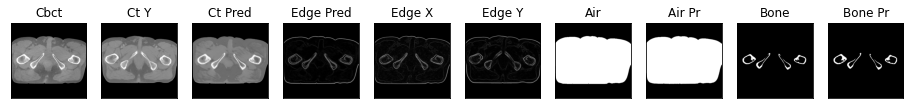

115it [00:51,  2.24it/s]

ssim score = 0.745915412902832
psnr score = 20.010337829589844
snr score = 12.057146072387695
mae error = 0.04774084314703941
air dice score = 0.996842789488348
bone dice score = 0.9324434758930477
contour dice score = 0.38991445302963257


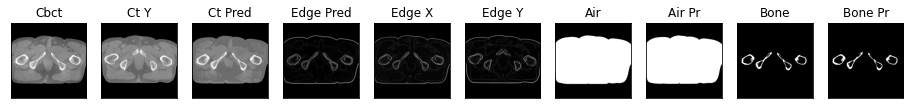

116it [00:51,  2.25it/s]

ssim score = 0.7472176551818848
psnr score = 20.025474548339844
snr score = 12.111356735229492
mae error = 0.0472756028175354
air dice score = 0.9966748925422609
bone dice score = 0.9384067889414398
contour dice score = 0.42921146750450134


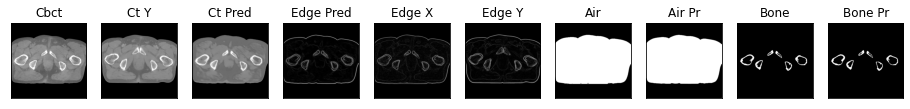

117it [00:52,  2.30it/s]

ssim score = 0.7492209076881409
psnr score = 20.188602447509766
snr score = 12.323165893554688
mae error = 0.04712609201669693
air dice score = 0.9959848199542304
bone dice score = 0.9326897291508086
contour dice score = 0.4302477240562439


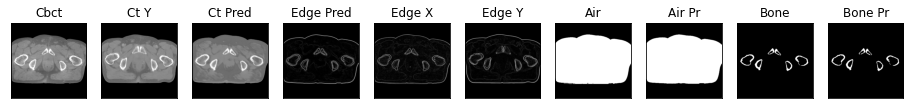

118it [00:52,  2.37it/s]

ssim score = 0.7419984340667725
psnr score = 20.031959533691406
snr score = 12.189132690429688
mae error = 0.048890501260757446
air dice score = 0.9962771470092716
bone dice score = 0.9253187613853068
contour dice score = 0.4477485120296478


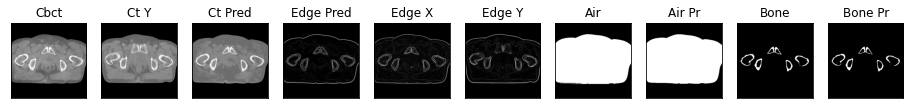

119it [00:53,  2.36it/s]

ssim score = 0.7285935282707214
psnr score = 19.945152282714844
snr score = 12.145103454589844
mae error = 0.05066969618201256
air dice score = 0.9968344193354609
bone dice score = 0.9182405263809157
contour dice score = 0.42006802558898926


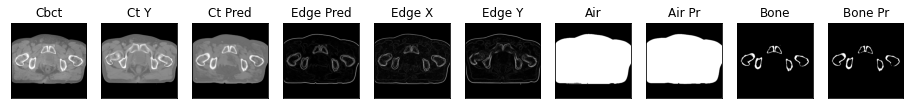

120it [00:53,  2.40it/s]

ssim score = 0.7283110022544861
psnr score = 19.888660430908203
snr score = 12.146949768066406
mae error = 0.051128316670656204
air dice score = 0.9968563236259389
bone dice score = 0.9145751266188566
contour dice score = 0.3901996314525604


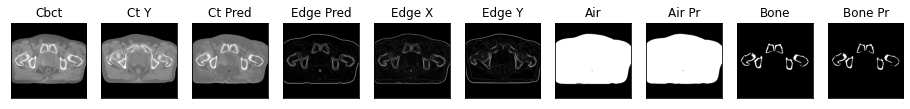

121it [00:53,  2.46it/s]

ssim score = 0.7205487489700317
psnr score = 19.788352966308594
snr score = 11.971269607543945
mae error = 0.052208974957466125
air dice score = 0.9970827699300917
bone dice score = 0.8748419721884235
contour dice score = 0.3766529858112335


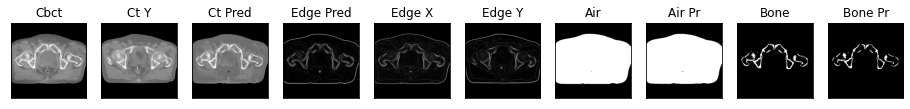

122it [00:54,  2.42it/s]

ssim score = 0.7268064618110657
psnr score = 19.852182388305664
snr score = 11.927881240844727
mae error = 0.05114194378256798
air dice score = 0.9969391512473552
bone dice score = 0.856634202535798
contour dice score = 0.34583714604377747


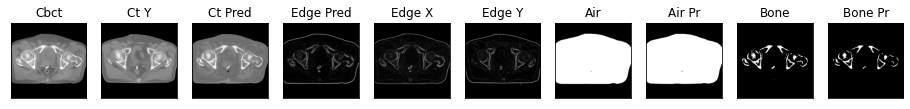

123it [00:55,  2.06it/s]

ssim score = 0.7332689762115479
psnr score = 20.1682186126709
snr score = 12.120830535888672
mae error = 0.04851120337843895
air dice score = 0.9973512374327748
bone dice score = 0.8455502787544337
contour dice score = 0.3506195545196533


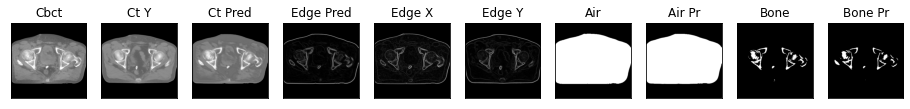

124it [00:55,  2.17it/s]

ssim score = 0.7418733835220337
psnr score = 20.41936492919922
snr score = 12.25954532623291
mae error = 0.045625995844602585
air dice score = 0.9976507529711928
bone dice score = 0.8946539229083641
contour dice score = 0.361623615026474


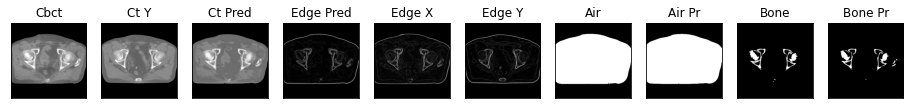

125it [00:55,  2.27it/s]

ssim score = 0.7402796149253845
psnr score = 20.56692123413086
snr score = 12.356456756591797
mae error = 0.04368068277835846
air dice score = 0.9976963859884717
bone dice score = 0.9177939646210427
contour dice score = 0.3583333194255829


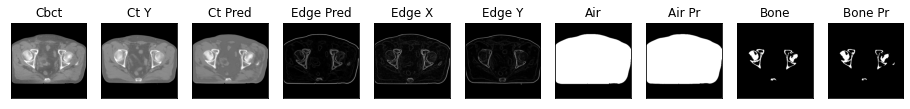

126it [00:56,  2.26it/s]

ssim score = 0.7394829988479614
psnr score = 20.36529541015625
snr score = 12.18698501586914
mae error = 0.04538244009017944
air dice score = 0.9978163656426053
bone dice score = 0.9182734443479593
contour dice score = 0.39516502618789673


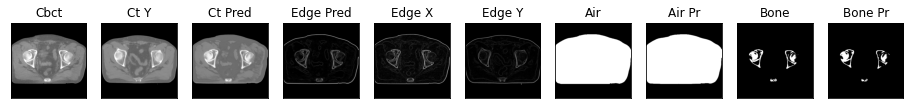

127it [00:56,  2.33it/s]

ssim score = 0.7402107119560242
psnr score = 20.165546417236328
snr score = 12.000713348388672
mae error = 0.046416234225034714
air dice score = 0.9977143923315543
bone dice score = 0.9230589061960057
contour dice score = 0.4132772386074066


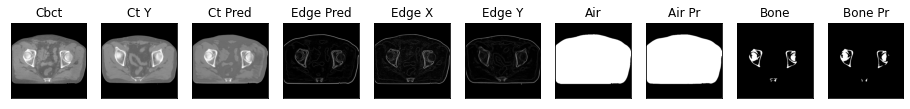

128it [00:57,  2.40it/s]

ssim score = 0.739197313785553
psnr score = 19.861589431762695
snr score = 11.55526351928711
mae error = 0.047616180032491684
air dice score = 0.9976264849120641
bone dice score = 0.9278078078086749
contour dice score = 0.397737979888916


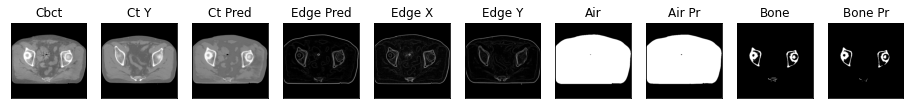

129it [00:57,  2.38it/s]

ssim score = 0.747132420539856
psnr score = 19.928260803222656
snr score = 11.562623977661133
mae error = 0.04676869884133339
air dice score = 0.997643982141386
bone dice score = 0.9338467886132052
contour dice score = 0.42478713393211365


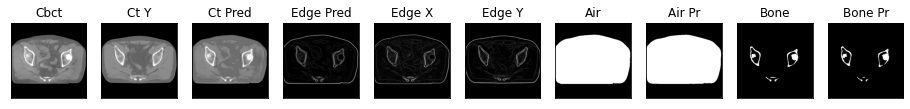

130it [00:57,  2.37it/s]

ssim score = 0.7460771203041077
psnr score = 20.25550651550293
snr score = 11.915519714355469
mae error = 0.044283200055360794
air dice score = 0.9977866679291747
bone dice score = 0.9088925259154593
contour dice score = 0.4100378751754761


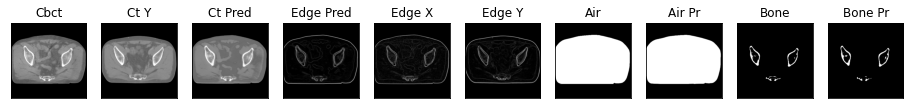

131it [00:58,  2.42it/s]

ssim score = 0.7418588399887085
psnr score = 20.145814895629883
snr score = 11.878643035888672
mae error = 0.04481126740574837
air dice score = 0.9974059354101731
bone dice score = 0.9327369688640507
contour dice score = 0.4367598295211792


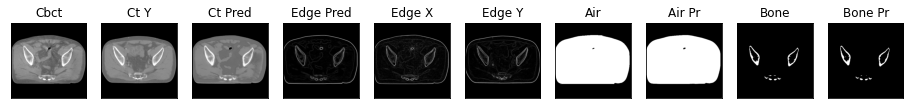

132it [00:58,  2.37it/s]

ssim score = 0.7351552248001099
psnr score = 19.74897003173828
snr score = 11.611026763916016
mae error = 0.04757891222834587
air dice score = 0.9974800529129048
bone dice score = 0.9333551127093539
contour dice score = 0.4444444477558136


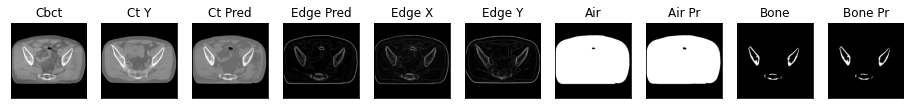

133it [00:59,  2.09it/s]

ssim score = 0.7303784489631653
psnr score = 19.603059768676758
snr score = 11.499076843261719
mae error = 0.04908861219882965
air dice score = 0.9973750752558715
bone dice score = 0.9297476960276515
contour dice score = 0.444124698638916


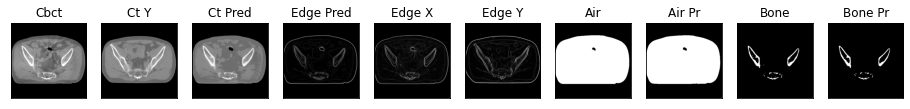

134it [00:59,  2.20it/s]

ssim score = 0.7232367396354675
psnr score = 19.609529495239258
snr score = 11.475753784179688
mae error = 0.049827273935079575
air dice score = 0.9972407880357688
bone dice score = 0.9084909252454818
contour dice score = 0.4080846905708313


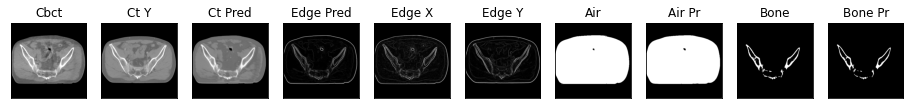

135it [01:00,  2.30it/s]

ssim score = 0.7214035391807556
psnr score = 19.869674682617188
snr score = 11.672525405883789
mae error = 0.04792864993214607
air dice score = 0.9975955860531893
bone dice score = 0.888888888890415
contour dice score = 0.46302562952041626


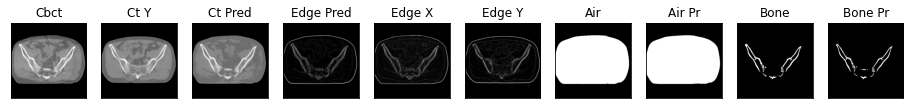

136it [01:00,  2.31it/s]

ssim score = 0.8147490620613098
psnr score = 22.752948760986328
snr score = 14.230337142944336
mae error = 0.03177949786186218
air dice score = 0.9982040283199515
bone dice score = 0.9141104294489066
contour dice score = 0.5503017902374268


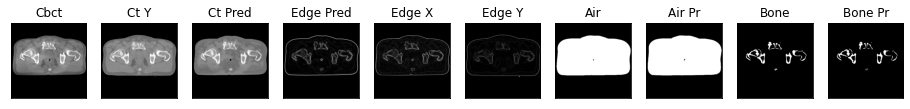

137it [01:01,  2.35it/s]

ssim score = 0.8178086876869202
psnr score = 22.88043785095215
snr score = 14.39784049987793
mae error = 0.03155086934566498
air dice score = 0.9982157725704783
bone dice score = 0.8974977772145625
contour dice score = 0.5335350632667542


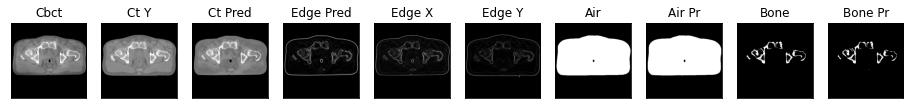

138it [01:01,  2.41it/s]

ssim score = 0.8207849264144897
psnr score = 23.05661964416504
snr score = 14.581809997558594
mae error = 0.031356923282146454
air dice score = 0.997931332132813
bone dice score = 0.8943025540288893
contour dice score = 0.5681012868881226


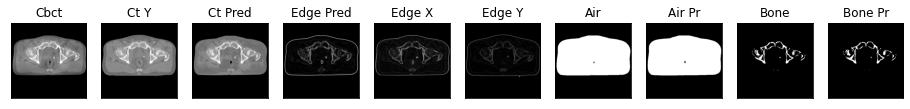

139it [01:01,  2.39it/s]

ssim score = 0.8247947692871094
psnr score = 23.081008911132812
snr score = 14.547779083251953
mae error = 0.030398497357964516
air dice score = 0.9982608436028167
bone dice score = 0.900920542636859
contour dice score = 0.5888324975967407


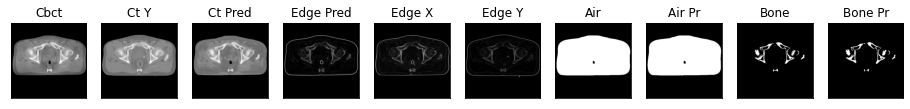

140it [01:02,  2.37it/s]

ssim score = 0.833274781703949
psnr score = 23.276670455932617
snr score = 14.587814331054688
mae error = 0.028643667697906494
air dice score = 0.9983379999101634
bone dice score = 0.8868678517309236
contour dice score = 0.6082527041435242


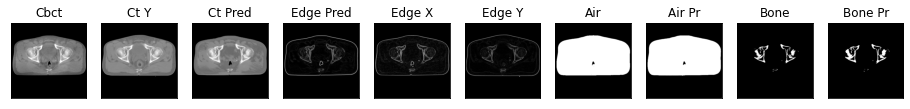

141it [01:02,  2.42it/s]

ssim score = 0.8353423476219177
psnr score = 23.48465347290039
snr score = 14.77499771118164
mae error = 0.02748645283281803
air dice score = 0.9981988202272501
bone dice score = 0.9161238867484232
contour dice score = 0.618293285369873


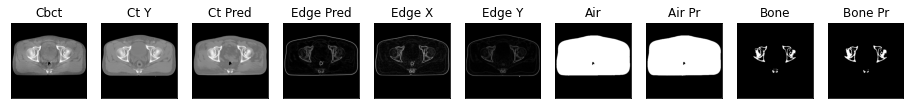

142it [01:03,  2.41it/s]

ssim score = 0.8296257853507996
psnr score = 23.459915161132812
snr score = 14.734630584716797
mae error = 0.02736029587686062
air dice score = 0.9979067526052663
bone dice score = 0.9258373205751483
contour dice score = 0.5859414935112


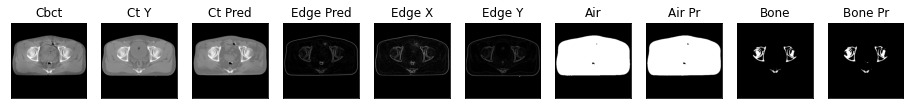

143it [01:03,  2.07it/s]

ssim score = 0.8219732046127319
psnr score = 22.875572204589844
snr score = 14.159649848937988
mae error = 0.029003096744418144
air dice score = 0.9980413657503702
bone dice score = 0.9210278487835191
contour dice score = 0.596707820892334


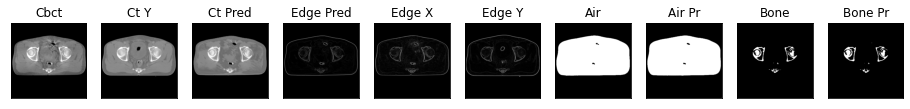

144it [01:04,  2.17it/s]

ssim score = 0.8205696940422058
psnr score = 22.8842716217041
snr score = 14.224128723144531
mae error = 0.029520051553845406
air dice score = 0.9980388148080855
bone dice score = 0.936335611849131
contour dice score = 0.5312661528587341


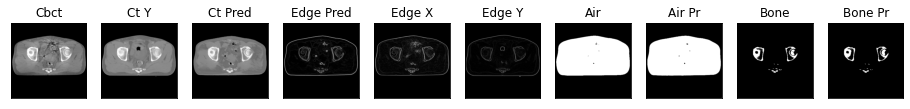

145it [01:04,  2.28it/s]

ssim score = 0.8202135562896729
psnr score = 22.454206466674805
snr score = 13.772136688232422
mae error = 0.03084910660982132
air dice score = 0.9978765992100052
bone dice score = 0.9366452693282634
contour dice score = 0.5230928659439087


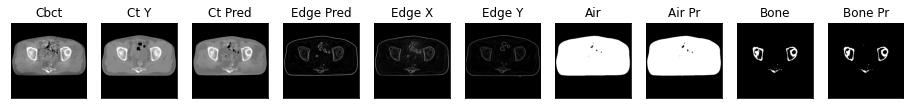

146it [01:04,  2.30it/s]

ssim score = 0.8206707239151001
psnr score = 21.94806671142578
snr score = 13.195220947265625
mae error = 0.03105708584189415
air dice score = 0.9980221911678251
bone dice score = 0.9147968465749727
contour dice score = 0.5466875433921814


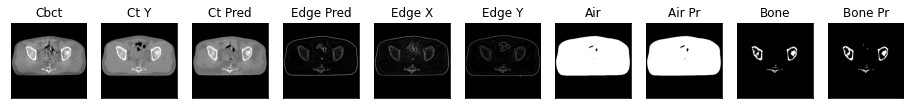

147it [01:05,  2.32it/s]

ssim score = 0.8183510899543762
psnr score = 22.236572265625
snr score = 13.439831733703613
mae error = 0.029945820569992065
air dice score = 0.998219920087401
bone dice score = 0.9193934557075915
contour dice score = 0.567836582660675


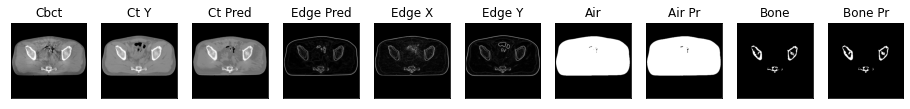

148it [01:05,  2.40it/s]

ssim score = 0.818588137626648
psnr score = 22.521575927734375
snr score = 13.723743438720703
mae error = 0.029110746458172798
air dice score = 0.9980591759552628
bone dice score = 0.9278155109788688
contour dice score = 0.5867508053779602


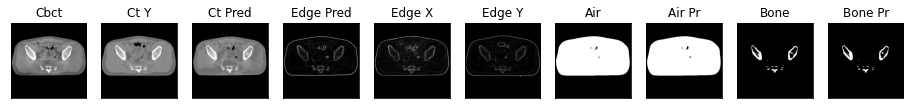

149it [01:06,  2.39it/s]

ssim score = 0.815767765045166
psnr score = 22.426061630249023
snr score = 13.641581535339355
mae error = 0.029897494241595268
air dice score = 0.9976802792912924
bone dice score = 0.9290596992263549
contour dice score = 0.5574288964271545


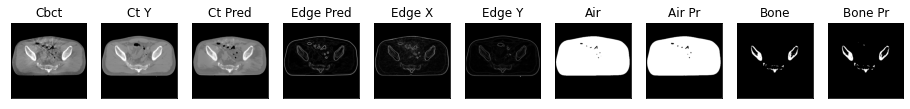

150it [01:06,  2.37it/s]

ssim score = 0.8159484267234802
psnr score = 22.372058868408203
snr score = 13.642786979675293
mae error = 0.03057720884680748
air dice score = 0.9975921897137744
bone dice score = 0.9172932330837977
contour dice score = 0.5638859272003174


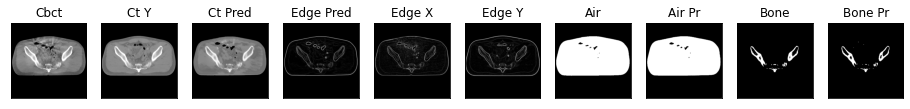

151it [01:06,  2.42it/s]

ssim score = 0.8169164657592773
psnr score = 21.97964096069336
snr score = 13.269739151000977
mae error = 0.03183399513363838
air dice score = 0.9975258083781267
bone dice score = 0.9056241426624743
contour dice score = 0.5569084286689758


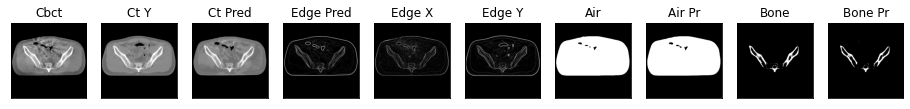

152it [01:07,  2.40it/s]

ssim score = 0.8213955760002136
psnr score = 22.04174041748047
snr score = 13.277097702026367
mae error = 0.0310222040861845
air dice score = 0.9968454258675103
bone dice score = 0.8993487270589202
contour dice score = 0.483014851808548


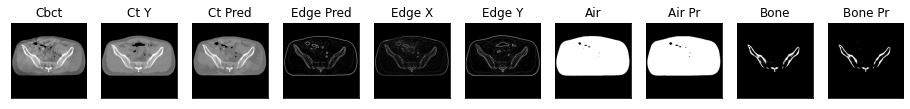

153it [01:08,  2.06it/s]

ssim score = 0.8246983885765076
psnr score = 22.47086524963379
snr score = 13.669870376586914
mae error = 0.029421839863061905
air dice score = 0.9973665458375953
bone dice score = 0.8956547443113264
contour dice score = 0.5031982660293579


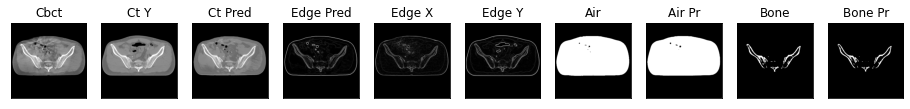

154it [01:08,  2.18it/s]

ssim score = 0.8272588849067688
psnr score = 22.64771270751953
snr score = 13.84678840637207
mae error = 0.028841162100434303
air dice score = 0.9971859810693294
bone dice score = 0.8820901583879506
contour dice score = 0.46631017327308655


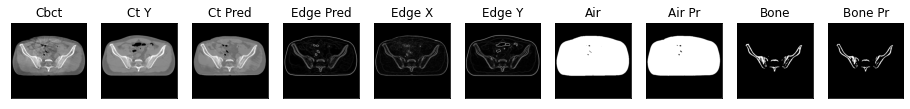

155it [01:08,  2.28it/s]

ssim score = 0.8256410360336304
psnr score = 22.800159454345703
snr score = 13.99781608581543
mae error = 0.028593454509973526
air dice score = 0.9972282393496865
bone dice score = 0.8915011484949128
contour dice score = 0.47147470712661743


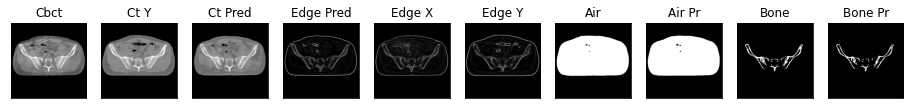

156it [01:09,  2.30it/s]

ssim score = 0.8188029527664185
psnr score = 22.269195556640625
snr score = 13.471888542175293
mae error = 0.029857728630304337
air dice score = 0.9969080274461265
bone dice score = 0.8858037294149204
contour dice score = 0.43205198645591736


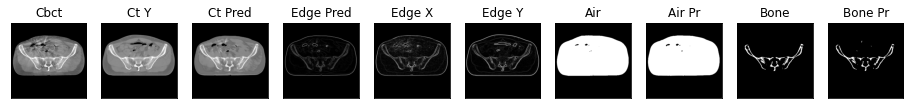

157it [01:09,  2.34it/s]

ssim score = 0.8140933513641357
psnr score = 21.731361389160156
snr score = 12.916784286499023
mae error = 0.031072285026311874
air dice score = 0.9963926036637403
bone dice score = 0.8716271463631557
contour dice score = 0.4082743525505066


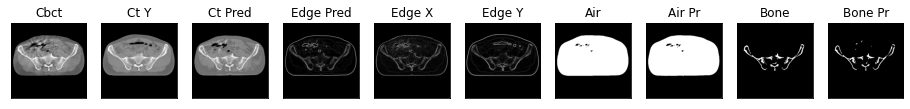

158it [01:10,  2.40it/s]

ssim score = 0.8082892894744873
psnr score = 21.43417739868164
snr score = 12.60097599029541
mae error = 0.032127510756254196
air dice score = 0.996267630534714
bone dice score = 0.8787801127642391
contour dice score = 0.40153592824935913


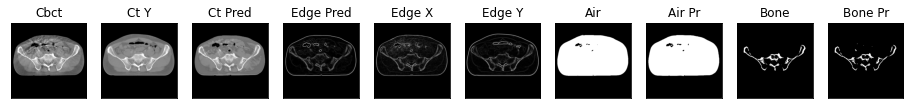

159it [01:10,  2.38it/s]

ssim score = 0.8001732230186462
psnr score = 21.111968994140625
snr score = 12.232829093933105
mae error = 0.03310134634375572
air dice score = 0.9958899678928427
bone dice score = 0.8874629812452188
contour dice score = 0.43929359316825867


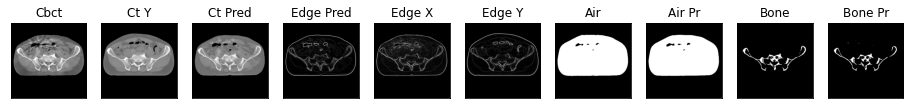

160it [01:10,  2.38it/s]

ssim score = 0.7950892448425293
psnr score = 21.104461669921875
snr score = 12.17152214050293
mae error = 0.03327607363462448
air dice score = 0.9954529611204447
bone dice score = 0.8881355932216932
contour dice score = 0.4086618423461914


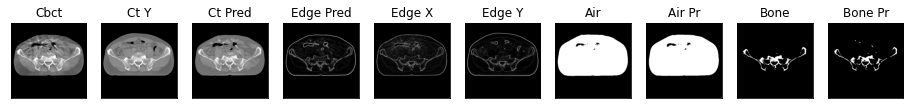

161it [01:11,  2.44it/s]

ssim score = 0.7891265749931335
psnr score = 20.724374771118164
snr score = 11.821898460388184
mae error = 0.035041168332099915
air dice score = 0.9951845395862722
bone dice score = 0.891792374392543
contour dice score = 0.3801560699939728


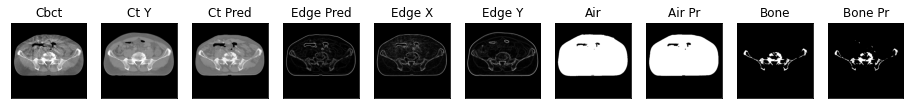

162it [01:11,  2.42it/s]

ssim score = 0.7836428284645081
psnr score = 20.474349975585938
snr score = 11.516648292541504
mae error = 0.03549827262759209
air dice score = 0.9954054528341054
bone dice score = 0.8835411471336216
contour dice score = 0.3672787845134735


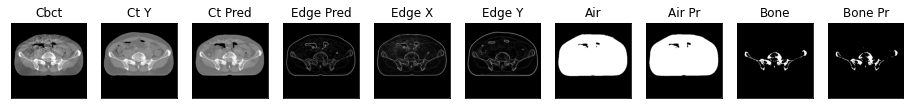

163it [01:12,  2.07it/s]

ssim score = 0.7956011891365051
psnr score = 21.16697120666504
snr score = 12.061737060546875
mae error = 0.032249029725790024
air dice score = 0.9956670576688326
bone dice score = 0.9063428497622227
contour dice score = 0.28555431962013245


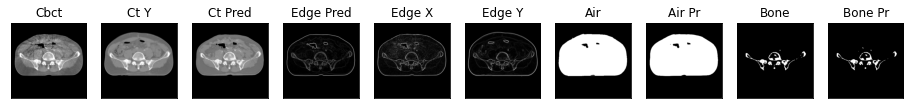

164it [01:12,  2.18it/s]

ssim score = 0.8507039546966553
psnr score = 25.155597686767578
snr score = 15.53650951385498
mae error = 0.022790009155869484
air dice score = 0.9963745911262423
bone dice score = 0.8962759310198382
contour dice score = 0.5104116201400757


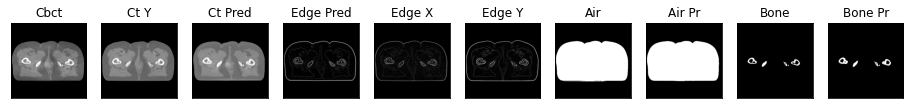

165it [01:13,  2.29it/s]

ssim score = 0.8517996072769165
psnr score = 25.429698944091797
snr score = 15.931624412536621
mae error = 0.02208777517080307
air dice score = 0.996355209410456
bone dice score = 0.9077586206916431
contour dice score = 0.516065239906311


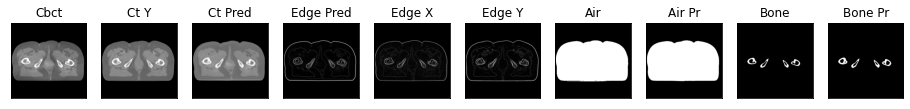

166it [01:13,  2.31it/s]

ssim score = 0.8476956486701965
psnr score = 25.433815002441406
snr score = 16.01865577697754
mae error = 0.022311504930257797
air dice score = 0.9964950121326529
bone dice score = 0.9123772102178315
contour dice score = 0.4787493944168091


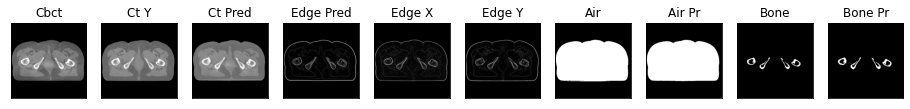

167it [01:14,  2.32it/s]

ssim score = 0.8431971073150635
psnr score = 25.31182861328125
snr score = 15.960115432739258
mae error = 0.02285182848572731
air dice score = 0.9967156063077783
bone dice score = 0.9208377706794314
contour dice score = 0.5


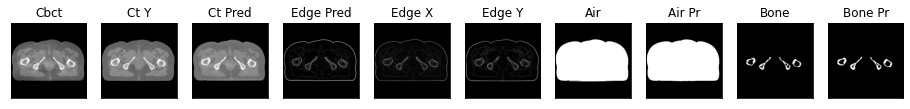

168it [01:14,  2.40it/s]

ssim score = 0.8448007106781006
psnr score = 25.251752853393555
snr score = 15.928499221801758
mae error = 0.022741593420505524
air dice score = 0.9965535927170286
bone dice score = 0.9338814662566995
contour dice score = 0.5036891102790833


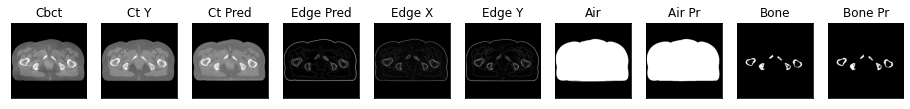

169it [01:14,  2.38it/s]

ssim score = 0.8453630805015564
psnr score = 25.17376708984375
snr score = 15.873470306396484
mae error = 0.022548209875822067
air dice score = 0.9965478721487538
bone dice score = 0.9340501792126514
contour dice score = 0.5111976861953735


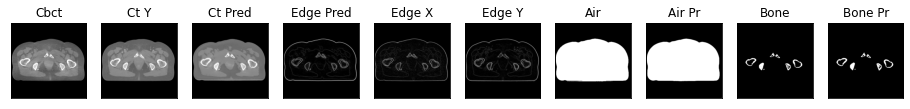

170it [01:15,  2.39it/s]

ssim score = 0.8424419164657593
psnr score = 25.150203704833984
snr score = 15.881233215332031
mae error = 0.02246355079114437
air dice score = 0.99643386106438
bone dice score = 0.9325605900960211
contour dice score = 0.4726921319961548


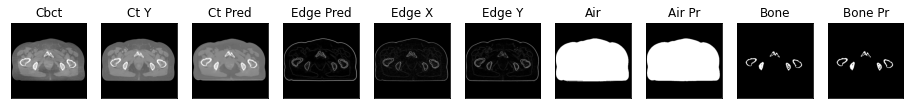

171it [01:15,  2.45it/s]

ssim score = 0.8394671678543091
psnr score = 24.898473739624023
snr score = 15.677865982055664
mae error = 0.02335277386009693
air dice score = 0.9963735072134917
bone dice score = 0.9319916724508676
contour dice score = 0.49482595920562744


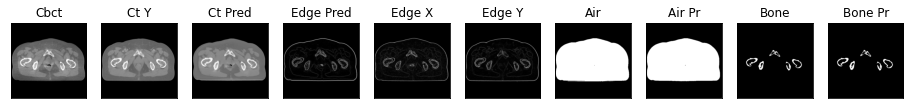

172it [01:16,  2.42it/s]

ssim score = 0.8409230709075928
psnr score = 24.550220489501953
snr score = 15.372358322143555
mae error = 0.0238018948584795
air dice score = 0.9962560273647777
bone dice score = 0.9253682487737256
contour dice score = 0.5014409422874451


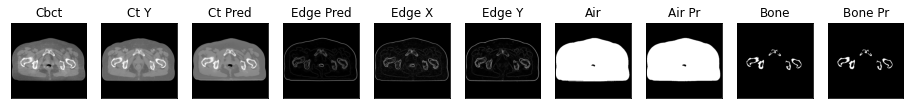

173it [01:16,  2.06it/s]

ssim score = 0.839407205581665
psnr score = 24.434316635131836
snr score = 15.344156265258789
mae error = 0.02427956461906433
air dice score = 0.9962277707921708
bone dice score = 0.9189189189200784
contour dice score = 0.4978981912136078


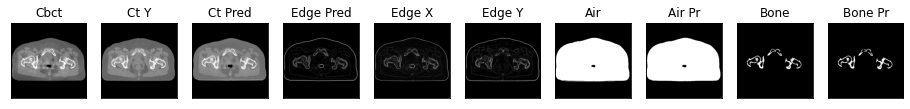

174it [01:17,  2.17it/s]

ssim score = 0.8422489762306213
psnr score = 25.207460403442383
snr score = 16.230571746826172
mae error = 0.02399183064699173
air dice score = 0.995951938206268
bone dice score = 0.9149380139939249
contour dice score = 0.47438856959342957


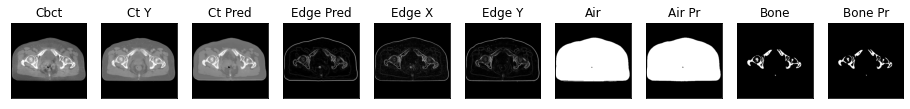

175it [01:17,  2.27it/s]

ssim score = 0.8466379046440125
psnr score = 24.670249938964844
snr score = 15.564811706542969
mae error = 0.02420785278081894
air dice score = 0.9963196860992996
bone dice score = 0.9064149736057204
contour dice score = 0.4916820824146271


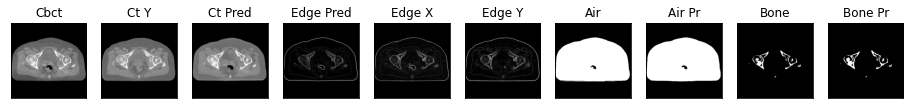

176it [01:17,  2.29it/s]

ssim score = 0.8479629158973694
psnr score = 24.768970489501953
snr score = 15.55411148071289
mae error = 0.023618442937731743
air dice score = 0.9962574153982695
bone dice score = 0.8815927348955362
contour dice score = 0.5009346008300781


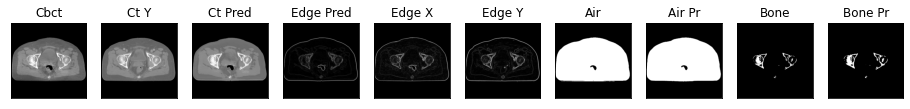

177it [01:18,  2.32it/s]

ssim score = 0.850675642490387
psnr score = 24.866437911987305
snr score = 15.62445068359375
mae error = 0.023711958900094032
air dice score = 0.9963472925733065
bone dice score = 0.9144246353336398
contour dice score = 0.5226960182189941


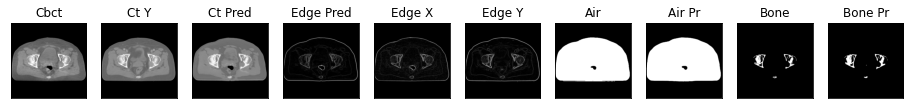

178it [01:18,  2.36it/s]

ssim score = 0.8526986837387085
psnr score = 25.537857055664062
snr score = 16.287864685058594
mae error = 0.02325310744345188
air dice score = 0.9967031723123095
bone dice score = 0.924201493724389
contour dice score = 0.5126050710678101


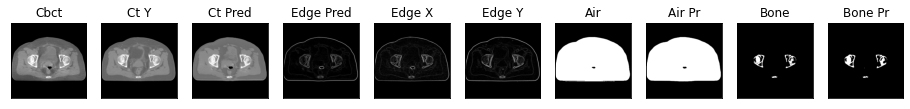

179it [01:19,  2.35it/s]

ssim score = 0.8524284958839417
psnr score = 26.215030670166016
snr score = 16.999267578125
mae error = 0.022289514541625977
air dice score = 0.9969354623805238
bone dice score = 0.9237875288695336
contour dice score = 0.526365339756012


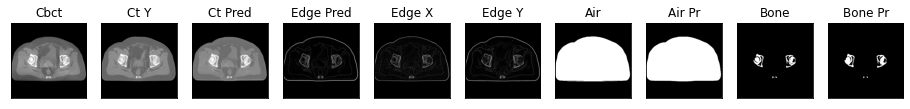

180it [01:19,  2.40it/s]

ssim score = 0.8485459685325623
psnr score = 25.67957305908203
snr score = 16.515300750732422
mae error = 0.02321358025074005
air dice score = 0.9974179988447128
bone dice score = 0.9439593586292434
contour dice score = 0.5267212390899658


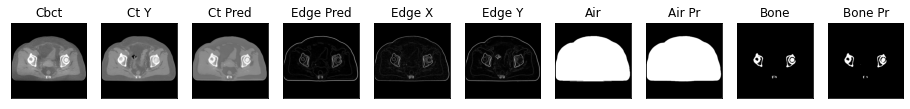

181it [01:19,  2.44it/s]

ssim score = 0.8364049196243286
psnr score = 24.7999267578125
snr score = 15.673213958740234
mae error = 0.02477433905005455
air dice score = 0.997439030282951
bone dice score = 0.9495122368654884
contour dice score = 0.5516908168792725


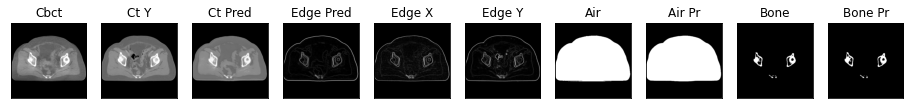

182it [01:20,  2.42it/s]

ssim score = 0.8190084099769592
psnr score = 23.201473236083984
snr score = 14.002321243286133
mae error = 0.028369784355163574
air dice score = 0.9969987666164197
bone dice score = 0.9302425413193767
contour dice score = 0.5320293307304382


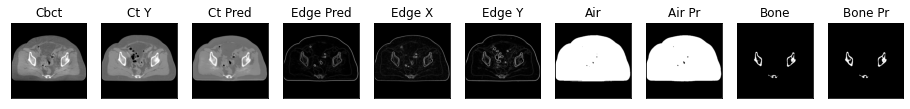

183it [01:21,  2.07it/s]

ssim score = 0.8120138049125671
psnr score = 22.901371002197266
snr score = 13.684226036071777
mae error = 0.030004961416125298
air dice score = 0.9971786833855819
bone dice score = 0.9356297093662943
contour dice score = 0.5049406886100769


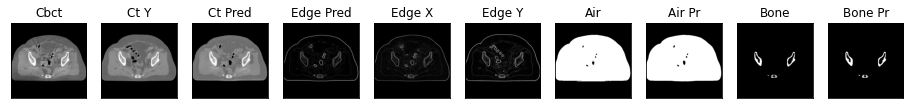

184it [01:21,  2.17it/s]

ssim score = 0.8095880746841431
psnr score = 23.49395751953125
snr score = 14.341728210449219
mae error = 0.028764108195900917
air dice score = 0.9972490425589317
bone dice score = 0.9339170314793847
contour dice score = 0.5037037134170532


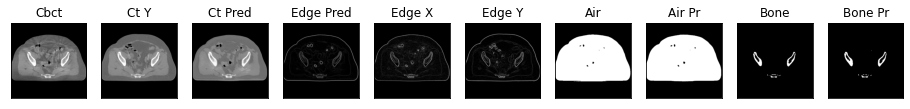

185it [01:21,  2.27it/s]

ssim score = 0.8118602633476257
psnr score = 23.579029083251953
snr score = 14.481893539428711
mae error = 0.028462985530495644
air dice score = 0.9969865228750329
bone dice score = 0.9416697047039433
contour dice score = 0.49576905369758606


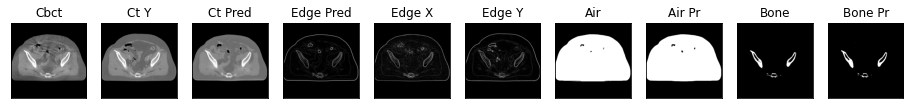

186it [01:22,  2.30it/s]

ssim score = 0.8092372417449951
psnr score = 22.91474151611328
snr score = 13.882035255432129
mae error = 0.03030628338456154
air dice score = 0.9968957049529743
bone dice score = 0.9349277838183735
contour dice score = 0.46289926767349243


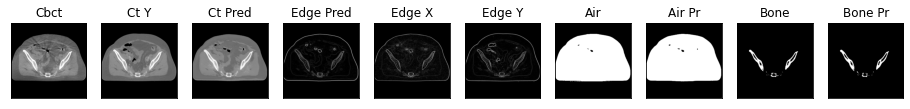

187it [01:22,  2.32it/s]

ssim score = 0.8083070516586304
psnr score = 22.82400894165039
snr score = 13.864163398742676
mae error = 0.030855633318424225
air dice score = 0.9968481601134683
bone dice score = 0.9261744966453495
contour dice score = 0.41913214325904846


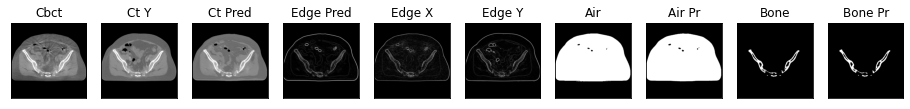

188it [01:23,  2.41it/s]

ssim score = 0.8066903948783875
psnr score = 22.83264923095703
snr score = 13.868512153625488
mae error = 0.0308806374669075
air dice score = 0.9964691473837838
bone dice score = 0.9093516924855228
contour dice score = 0.40507563948631287


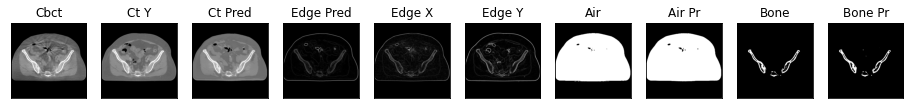

189it [01:23,  2.39it/s]

ssim score = 0.8063818216323853
psnr score = 22.88702964782715
snr score = 13.900716781616211
mae error = 0.03089403174817562
air dice score = 0.9971038797690863
bone dice score = 0.918019142739381
contour dice score = 0.4126213490962982


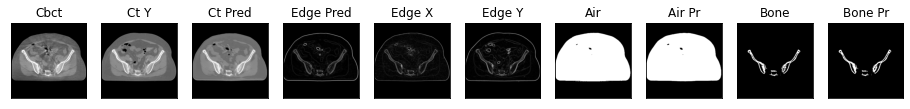

190it [01:23,  2.38it/s]

ssim score = 0.813951849937439
psnr score = 23.617677688598633
snr score = 14.643000602722168
mae error = 0.02902531623840332
air dice score = 0.997321708226001
bone dice score = 0.9250786388343569
contour dice score = 0.43201541900634766


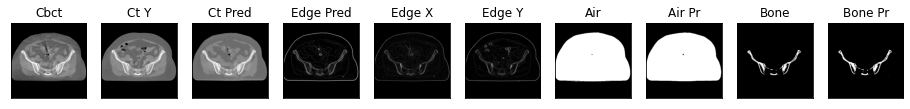

191it [01:24,  2.26it/s]


In [44]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [45]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [46]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [47]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:20,  9.39it/s]


(0.8222946555826677,
 23.001738423452327,
 14.006010410049198,
 0.029874408061747775,
 0.9968701985780735,
 0.9086630359074599,
 0.4728549525375766,
 0.5167539267015707,
 0.4973821989528796)

In [48]:
# import torchvision.models as models
# models.vgg16(pretrained=True)